# Credit Card Fraud Detection
*transformers with an attention mechanism approach*

In [ ]:
Data Science Project- Thesis

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import itertools

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Describing the data
print("The dataframe can be described as:")
print(df.describe())

# Finding null values
print("The null-values within the dataframe are: ", df.isnull().sum())

# Finding NA values
print("The N/A values within the dataframe are: ", df.isna().sum())

In [ ]:

# Visualize the class label distribution
sns.countplot(x='Class', data=df)
plt.title("Class Label Distribution")
plt.show()

# Visualize the transactions amount distribution
sns.distplot(df['Amount'], kde=False)
plt.title("Transactions Amount Distribution")
plt.show()

In [ ]:
# Heatmap of Feature Correlations
plt.figure(figsize=(40, 20))
sns.heatmap(df.corr(), annot=True, cmap='rocket', square=True, fmt='.2f', linewidths=1)
plt.title("Heatmap of Feature Correlations")
plt.show()

In [ ]:
# Transaction times
plt.figure(figsize=(10, 6))
sns.histplot(df['Time'], bins=50, kde=False) # type: ignore
plt.title("Transaction Times Histogram")
plt.xlabel("Time (in seconds)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Box plot of transaction amounts for each class
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Box Plot of Transaction Amounts for Each Class")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Transaction Amount")
plt.show()

In [ ]:
# Preprocessing steps

# From the boxplot above we can say that its best to remove non-fraudulent data wherein its amount exceed the
# maximum amount of fraudulent transactions
max_fraud_amount = df.loc[df['Class']==1,"Amount"].max()
df = df[df["Amount"]<=max_fraud_amount]

# Create a boxplot to confirm
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Box Plot of Transaction Amounts after filtering for Each Class")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Transaction Amount")
plt.show()

# Droppping the Time column
df = df.drop(["Time"], axis=1)

# Transforming the Amount column
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

In [ ]:
# Split data into features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Feature distribution of each class
df_fraud = df[df['Class'] == 1]
df_non_fraud = df[df['Class'] == 0]

plt.figure(figsize=(15, 20))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(6, 5, i)
    sns.kdeplot(data=df_non_fraud, x=col, fill=True, color='blue', label='Non-Fraudulent')
    sns.kdeplot(data=df_fraud, x=col, fill=True, color='red', label='Fraudulent')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Equalize the number of fraudulent and non-fraudulent transactions within the dataframe

minority_count = df[df['Class'] == 1].shape[0]
majority_count = df[df['Class'] == 0].shape[0]

minor_rows_list = [492, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
ratio = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

dataframes_dict = {}

n_plots = len(minor_rows_list)
n_cols = 3
n_rows = n_plots // n_cols + (n_plots % n_cols > 0)

for r in ratio:

    # Creating the figures for plotting
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
    fig.suptitle(f"Class distribution for the ratio 1:{r}", fontsize=16, y=1.02)

    for index, minor_rows in enumerate(minor_rows_list):
        minority_count = minor_rows
        majority_count = minor_rows * r

        smote = SMOTE(sampling_strategy={1: minority_count}) # type: ignore
        under = RandomUnderSampler(sampling_strategy={0: majority_count}) # type: ignore
        pipeline = Pipeline(steps=[('s', smote), ('u', under)])
        X_new, y_new = pipeline.fit_resample(X, y) # type: ignore

        column_names = df.columns[:-1]
        X_new_df = pd.DataFrame(X_new, columns=column_names)
        y_new_df = pd.DataFrame(y_new, columns=['Class'])
        df_new = pd.concat([X_new_df, y_new_df], axis=1)

        # Store the DataFrame in the dictionary
        dataframes_dict[(r, minor_rows)] = df_new

        # Create a boxplot to confirm equal distribution
        ax = axes[index // n_cols, index % n_cols]
        sns.countplot(x='Class', data=df_new, palette=['blue', 'red'], ax=ax)
        ax.set_title(f"Total Number of Rows: {minor_rows*(r+1)} with {minor_rows} fraud rows")
        ax.set_xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
        ax.set_ylabel("Transaction Amount")

    for i in range(n_plots, n_rows * n_cols):
        fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [ ]:
for r in ratio:
    for index, minor_rows in enumerate(minor_rows_list):

        df_new = dataframes_dict[(r, minor_rows)]

        # Heatmap of Feature Correlations with the new dataframes
        plt.figure(figsize=(40, 20))
        sns.heatmap(df_new.corr(), annot=True, cmap='rocket', square=True, fmt='.2f', linewidths=0.5) # type: ignore
        plt.title(f"Heatmap of Feature Correlations with the new dataframe of Total Rows: {minor_rows*(r+1)} with {minor_rows} rows of fraud transactions of ratio 1:{r}", fontsize=16, y=1.02)
        plt.show()

In [ ]:
# Adding Logistic-Regression, KNN, Decision Tree, Naive Bayes and Random Forest classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Create a Multiple attention layer
class Multi_Attention(nn.Module):
    def __init__(self, samp_model, num_heads):
        super(Multi_Attention, self).__init__()
        assert samp_model % num_heads == 0

        self.samp_model = samp_model
        self.num_heads = num_heads
        self.count = samp_model // num_heads

        self.Wq = nn.Linear(samp_model, samp_model)
        self.Wk = nn.Linear(samp_model, samp_model)
        self.Wv = nn.Linear(samp_model, samp_model)
        self.Wo = nn.Linear(samp_model, samp_model)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        Q, K, V = self.split_heads(Q, K, V)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.count)
        attention_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention_weights, V)
        attended_values = self.combine_heads(attended_values)

        return self.Wo(attended_values).squeeze(1)

    def split_heads(self, Q, K, V):
        batch_size = Q.size(0)
        Q = Q.view(batch_size, -1, self.num_heads, self.count).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.count).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.count).transpose(1, 2)
        return Q, K, V

    def combine_heads(self, attended_values):
        batch_size = attended_values.size(0)
        return attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.samp_model)

# Create the model with attention mechanism
class CreditCardFraudModel(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(CreditCardFraudModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(128)
        )

        self.multi_attention = Multi_Attention(128, 2)
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(64)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(32),
        )
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.multi_attention(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)

# Create the model with attention, LSTM and GRU as well
class CreditCardFraudModel_lstmgru(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(CreditCardFraudModel_lstmgru, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(128)
        )

        self.multi_attention = Multi_Attention(128, 2)

        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.gru = nn.GRU(64, 32, batch_first=True)

        self.layer2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(16)
        )

        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.multi_attention(x)

        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = x.squeeze(1)

        x = self.layer2(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)

# Plotting confusion matrix
def plot_confusion_matrix(ax, conf_mat, split, name, total_desired_rows):
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues) # type: ignore
    ax.set_title(f'{name} (Split {split})')
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(['Non-Fraud', 'Fraud'])
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        ax.text(j, i, format(conf_mat[i, j], 'd'), horizontalalignment="center", color="white" if conf_mat[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, scheduler, criterion, device):
    model.train()
    running_loss_avg = 0.0
    for epoch in range(num_epochs):
        alpha = 0.1
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            running_loss_avg = alpha * loss.item() + (1 - alpha) * running_loss_avg

        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred.extend(outputs.squeeze().tolist())
            y_true.extend(labels.tolist())

    y_pred = np.array(y_pred)
    y_pred_labels = (y_pred >= 0.5).astype(int)

    # This is for accuracy
    correct = np.sum(y_true == y_pred_labels)
    total = len(y_true)
    accuracy = correct / total

    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred)

    conf_mat = confusion_matrix(y_true, y_pred_labels)

    return precision, recall, f1, roc_auc, accuracy, conf_mat, running_loss_avg



In [ ]:
# Creating X and y for all the dataframes
X_new_alldf = {}
Y_new_alldf = {}

for r in ratio:
    for minor_rows in minor_rows_list:
        df_new = dataframes_dict[(r,minor_rows)]
        X_new_alldf[(r, minor_rows)] = df_new.iloc[:, :-1].values
        Y_new_alldf[(r, minor_rows)] = df_new.iloc[:, -1].values


##########################################################################

This is for ratio 1:1

##########################################################################

This is Split number: 1 for 492 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9289, Precision: 0.9565, Recall: 0.8980, F1-score: 0.9263, ROC-AUC: 0.9288

K-Nearest Neighbors:
Accuracy: 0.9289, Precision: 0.9565, Recall: 0.8980, F1-score: 0.9263, ROC-AUC: 0.9288

Decision Tree:
Accuracy: 0.8528, Precision: 0.8286, Recall: 0.8878, F1-score: 0.8571, ROC-AUC: 0.8530

Naive Bayes:
Accuracy: 0.9036, Precision: 0.9647, Recall: 0.8367, F1-score: 0.8962, ROC-AUC: 0.9032


***************************************************************************

For the FraudModel:
Accuracy: 0.9289, Precision: 0.9667, Recall: 0.8878, F1-score: 0.9255, ROC-AUC: 0.9617


For the FraudModel_lstmgru:
Accuracy: 0.9340, Precision: 0.9670, Recall: 0.8980, F1-score: 0.9312, ROC-AUC: 0.9721

**************************

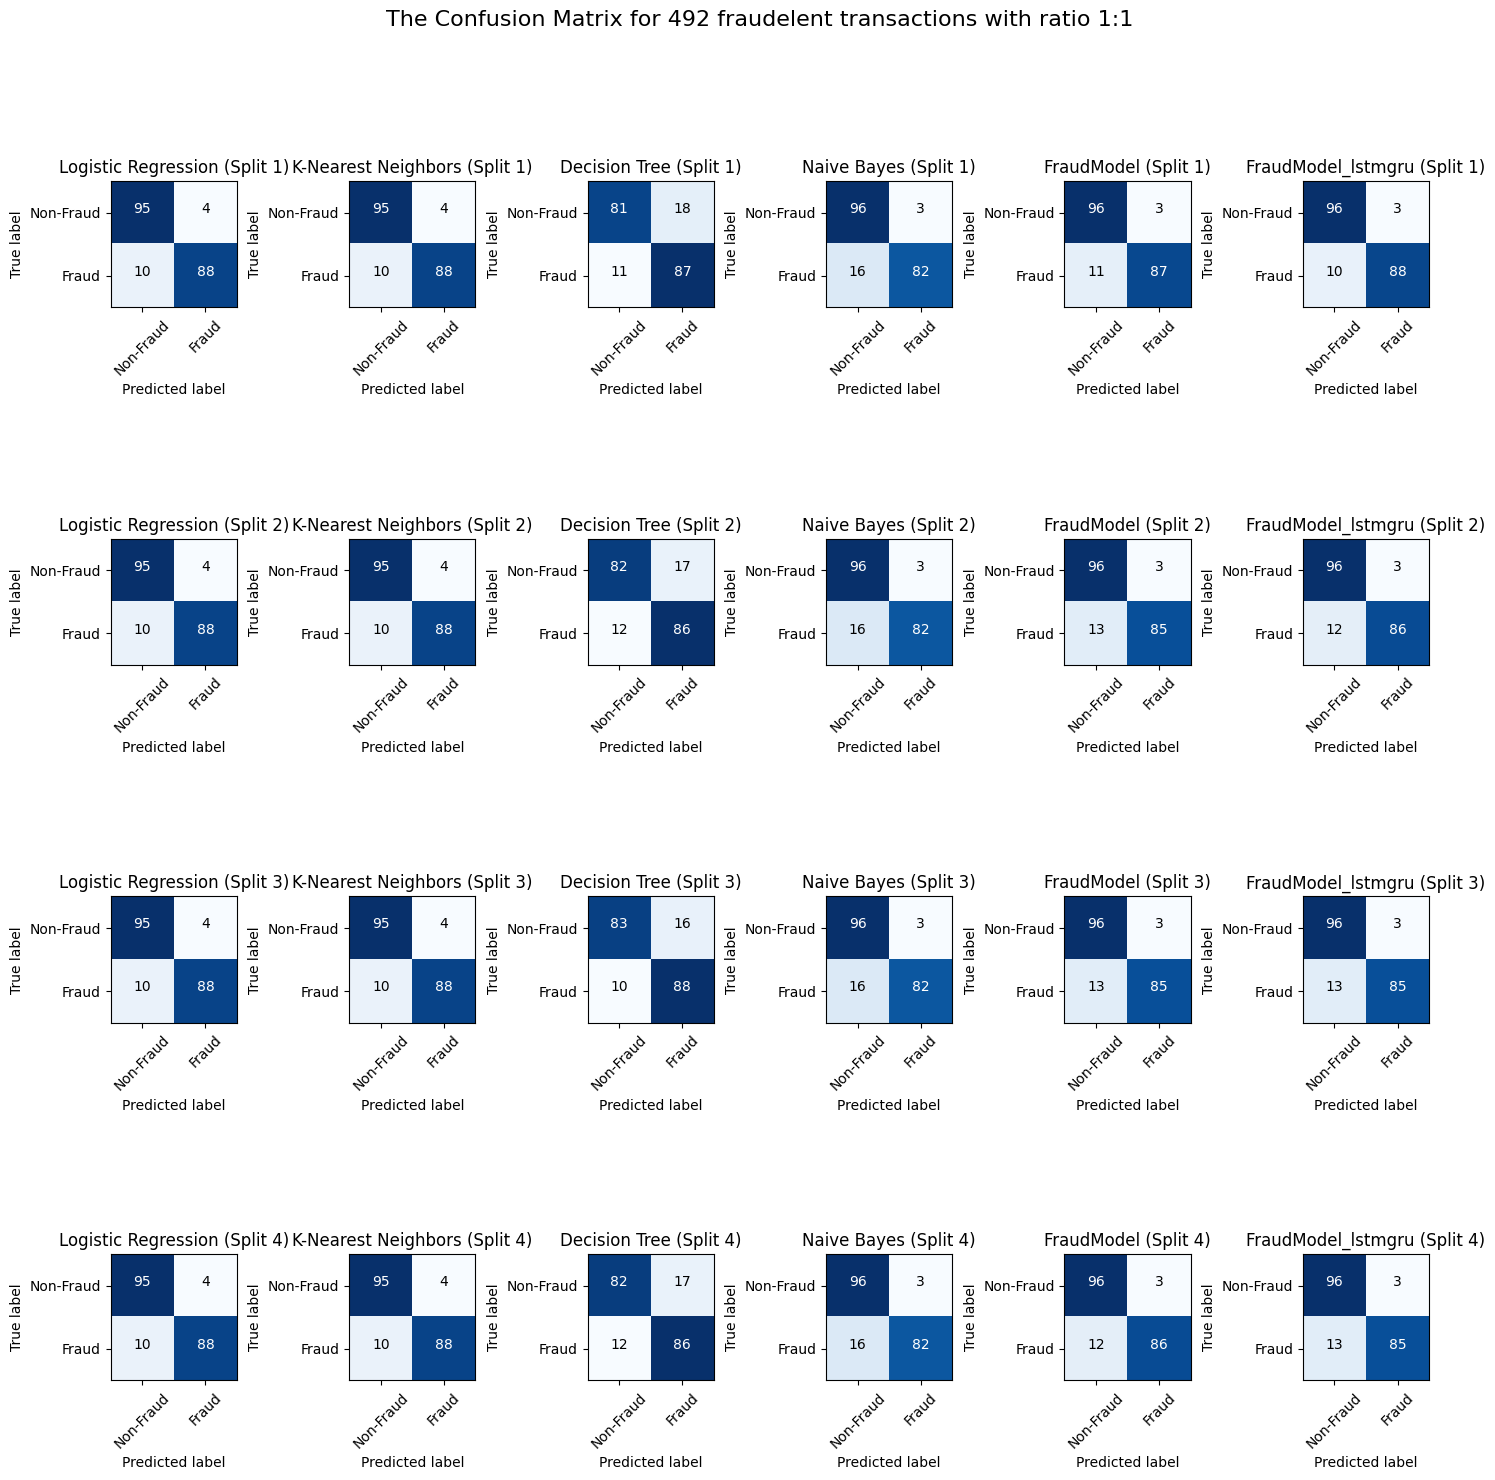

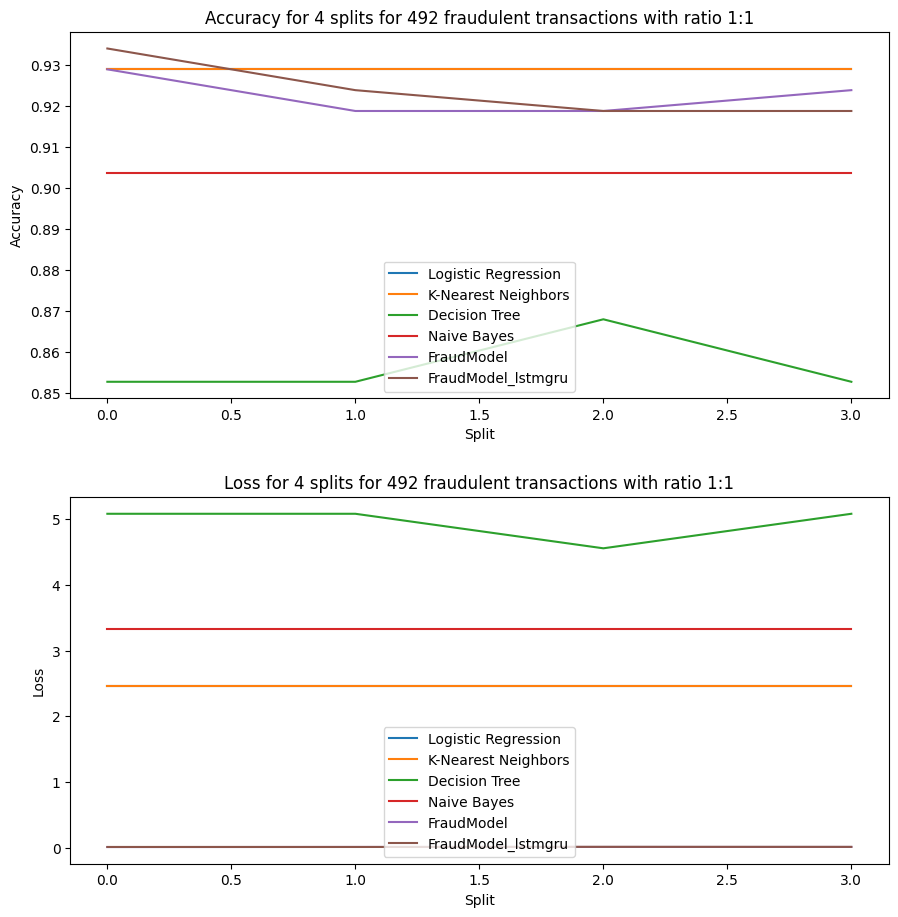

This is Split number: 1 for 500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9450, Precision: 0.9895, Recall: 0.9038, F1-score: 0.9447, ROC-AUC: 0.9467

K-Nearest Neighbors:
Accuracy: 0.9250, Precision: 0.9785, Recall: 0.8750, F1-score: 0.9239, ROC-AUC: 0.9271

Decision Tree:
Accuracy: 0.8900, Precision: 0.8942, Recall: 0.8942, F1-score: 0.8942, ROC-AUC: 0.8898

Naive Bayes:
Accuracy: 0.9050, Precision: 0.9670, Recall: 0.8462, F1-score: 0.9026, ROC-AUC: 0.9075


***************************************************************************

For the FraudModel:
Accuracy: 0.9350, Precision: 1.0000, Recall: 0.8750, F1-score: 0.9333, ROC-AUC: 0.9820


For the FraudModel_lstmgru:
Accuracy: 0.9400, Precision: 1.0000, Recall: 0.8846, F1-score: 0.9388, ROC-AUC: 0.9778

***************************************************************************

This is Split number: 2 for 500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9450, Precision: 0.

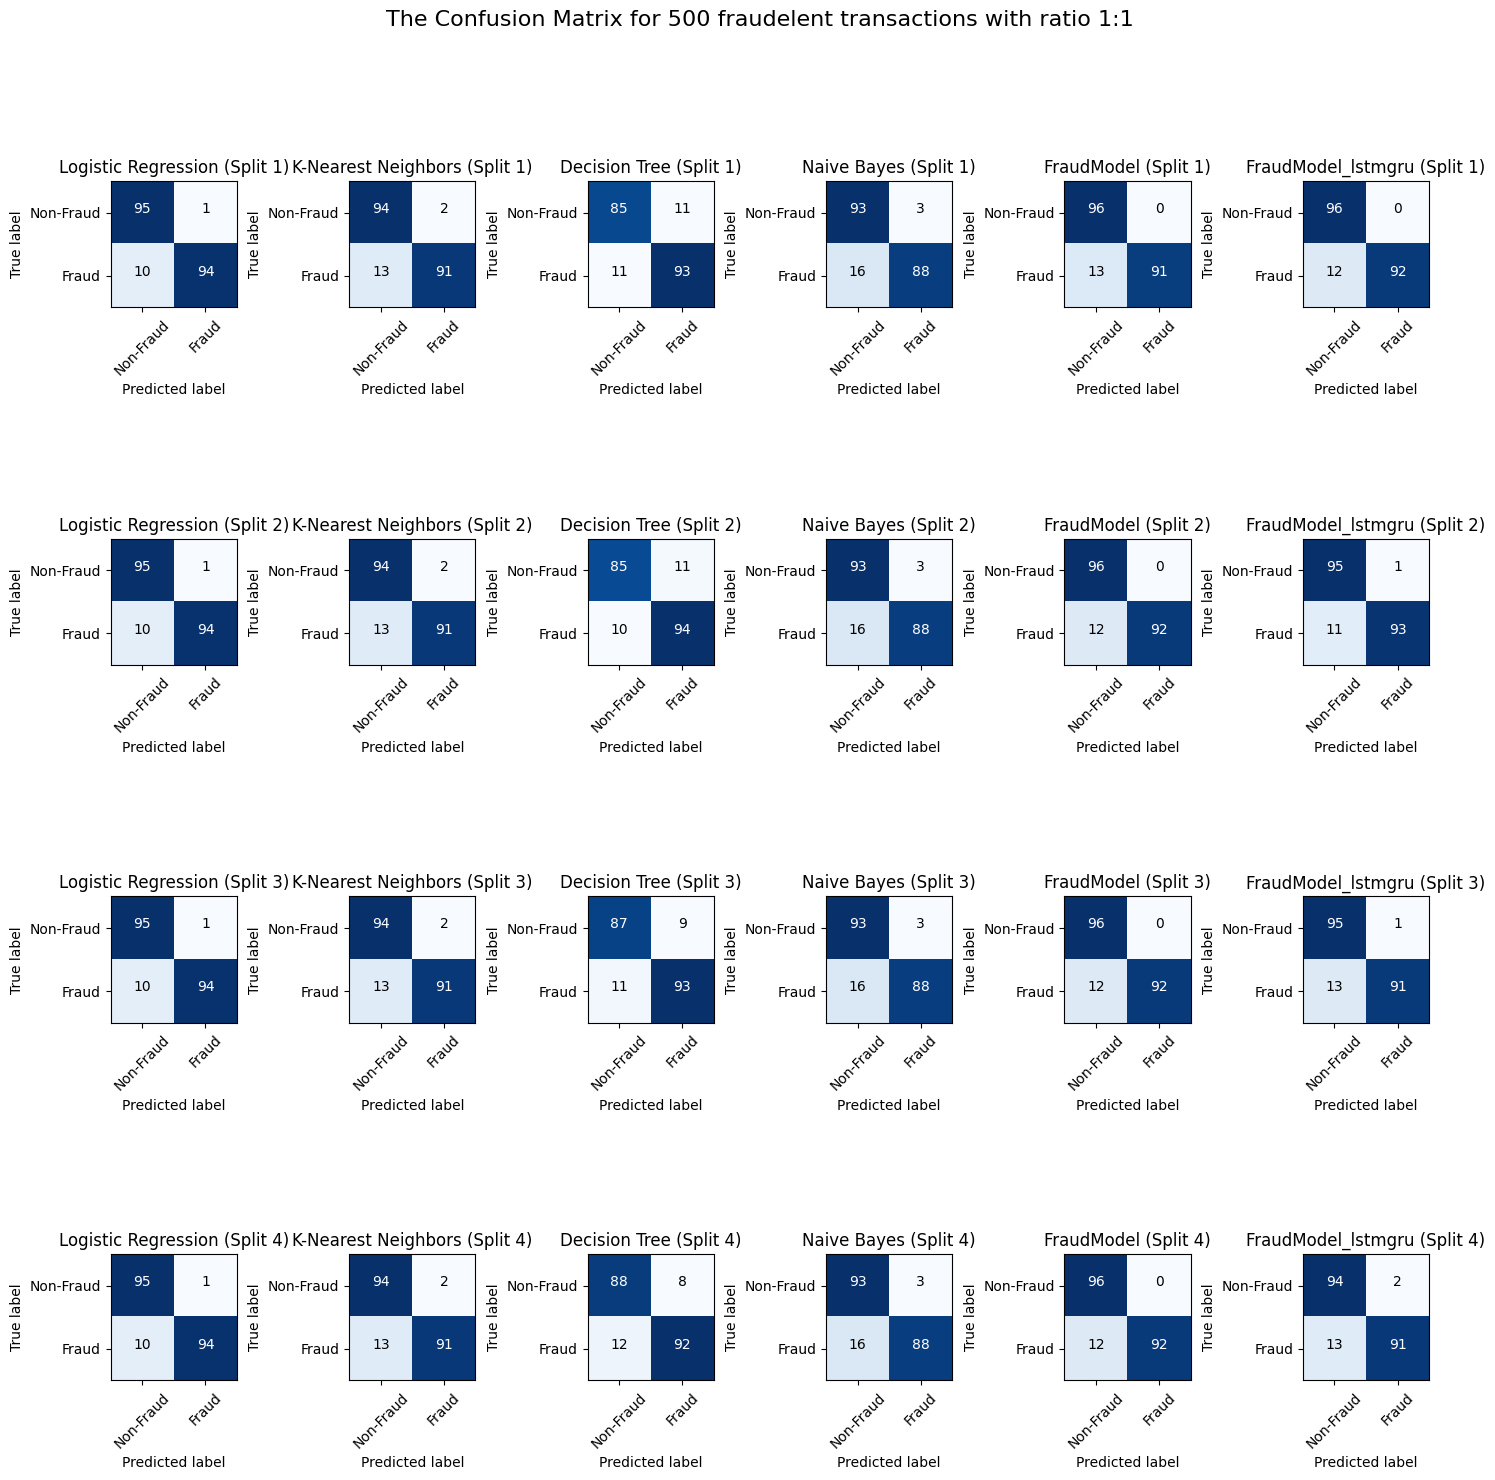

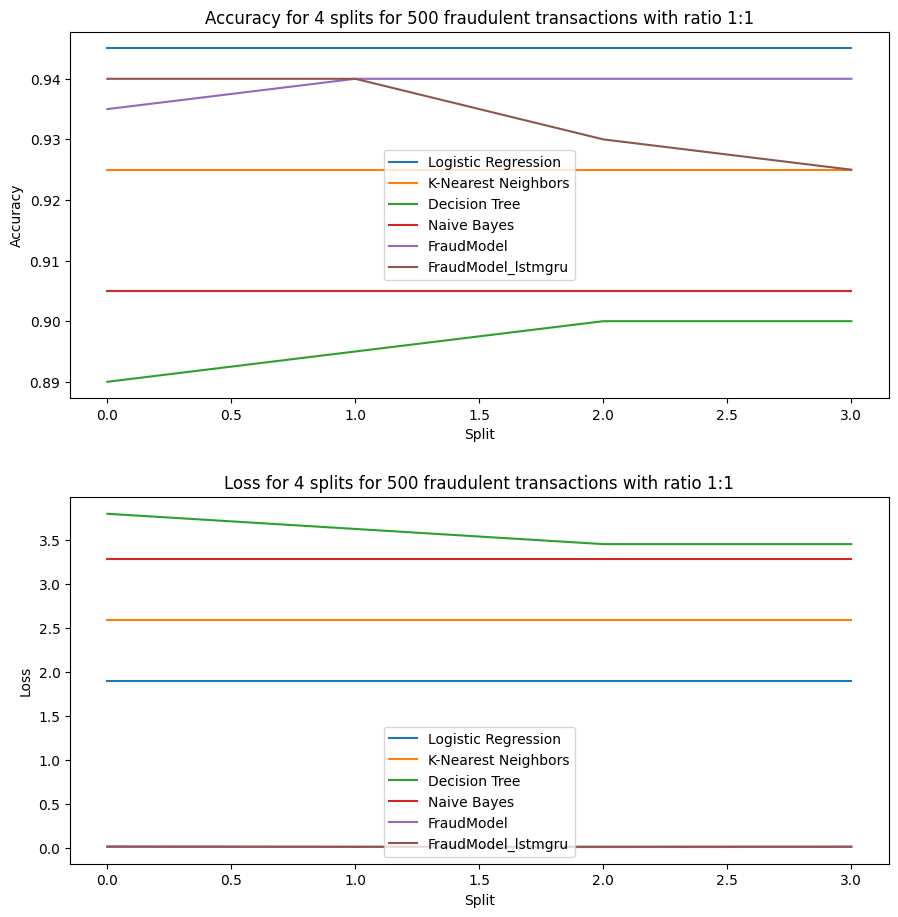

This is Split number: 1 for 1000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9450, Precision: 0.9543, Recall: 0.9353, F1-score: 0.9447, ROC-AUC: 0.9450

K-Nearest Neighbors:
Accuracy: 0.9550, Precision: 0.9463, Recall: 0.9652, F1-score: 0.9557, ROC-AUC: 0.9549

Decision Tree:
Accuracy: 0.9400, Precision: 0.9234, Recall: 0.9602, F1-score: 0.9415, ROC-AUC: 0.9399

Naive Bayes:
Accuracy: 0.9200, Precision: 0.9721, Recall: 0.8657, F1-score: 0.9158, ROC-AUC: 0.9203


***************************************************************************

For the FraudModel:
Accuracy: 0.9525, Precision: 0.9643, Recall: 0.9403, F1-score: 0.9521, ROC-AUC: 0.9892


For the FraudModel_lstmgru:
Accuracy: 0.9500, Precision: 0.9641, Recall: 0.9353, F1-score: 0.9495, ROC-AUC: 0.9900

***************************************************************************

This is Split number: 2 for 1000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9450, Precision: 

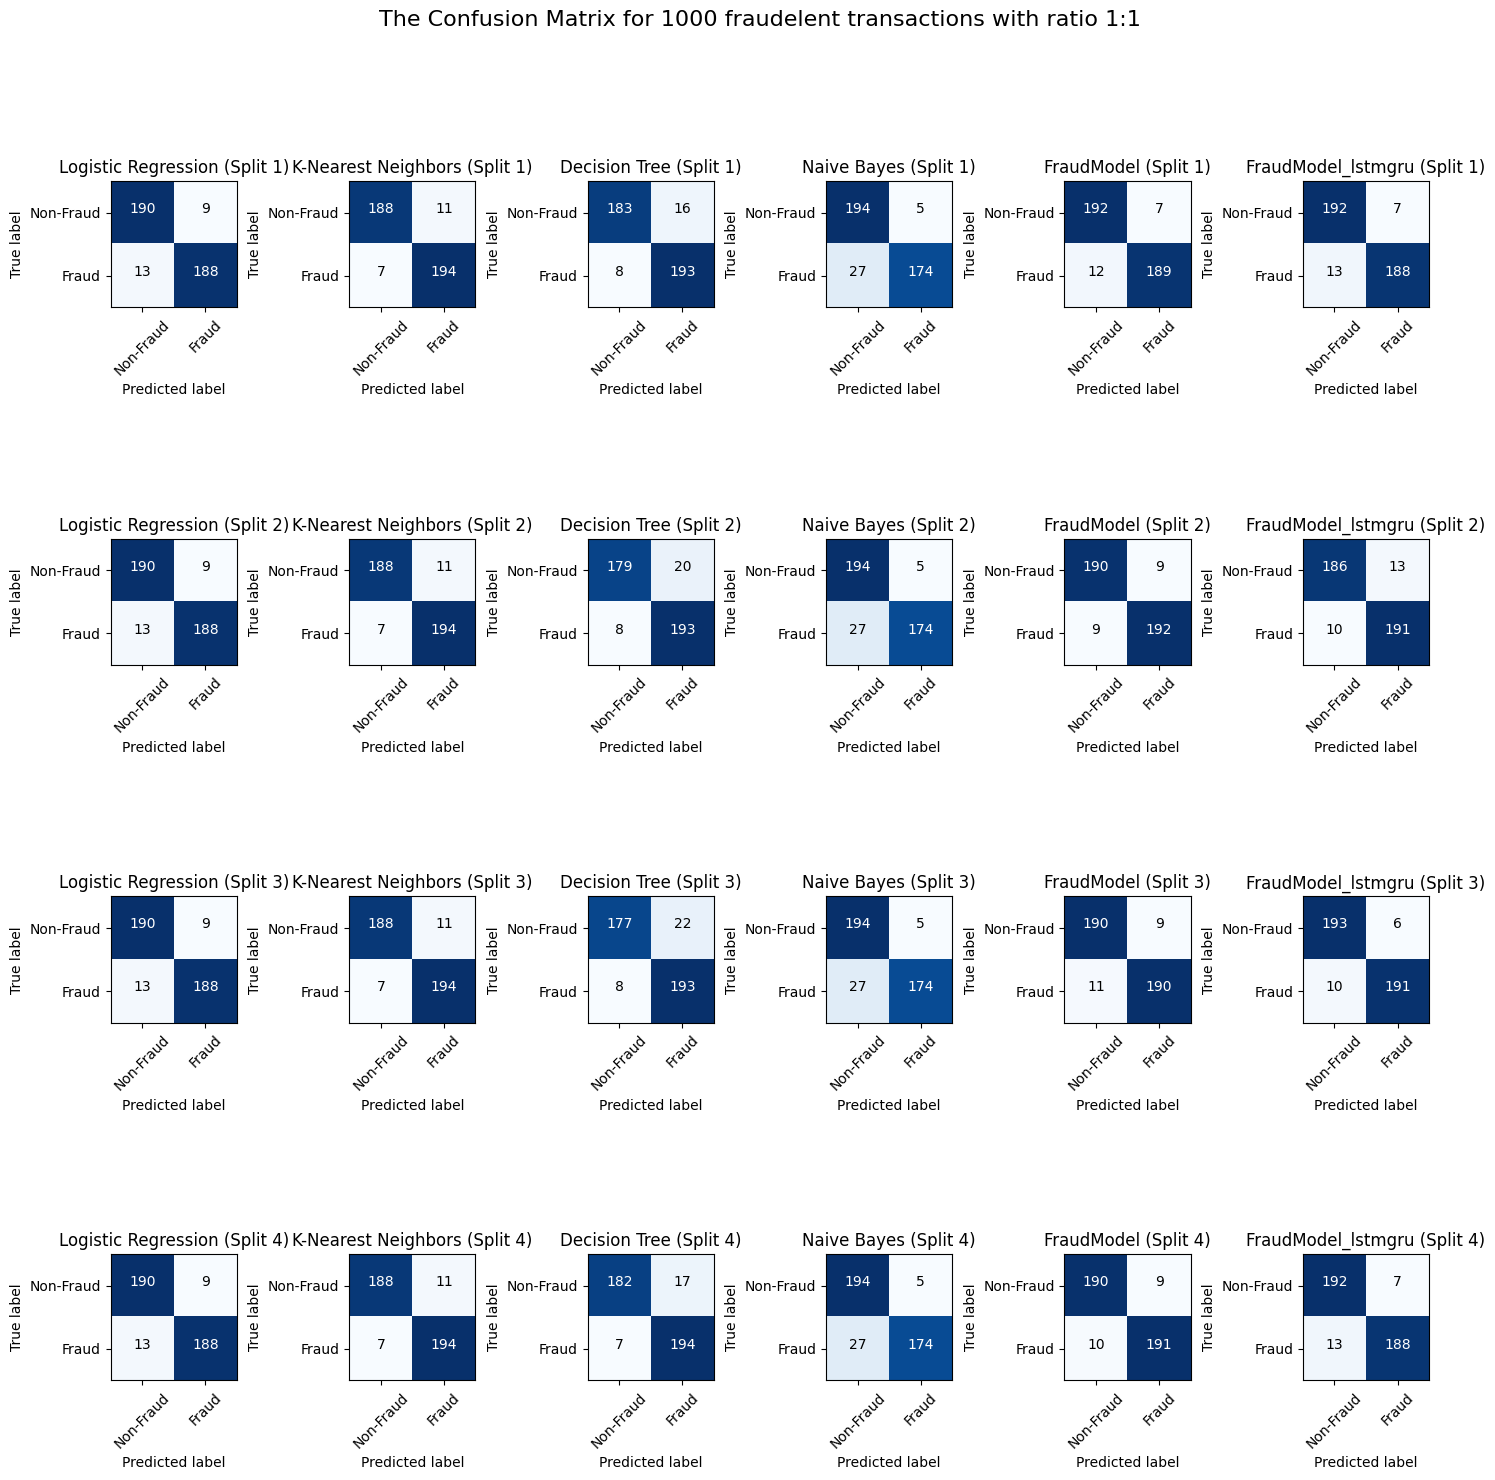

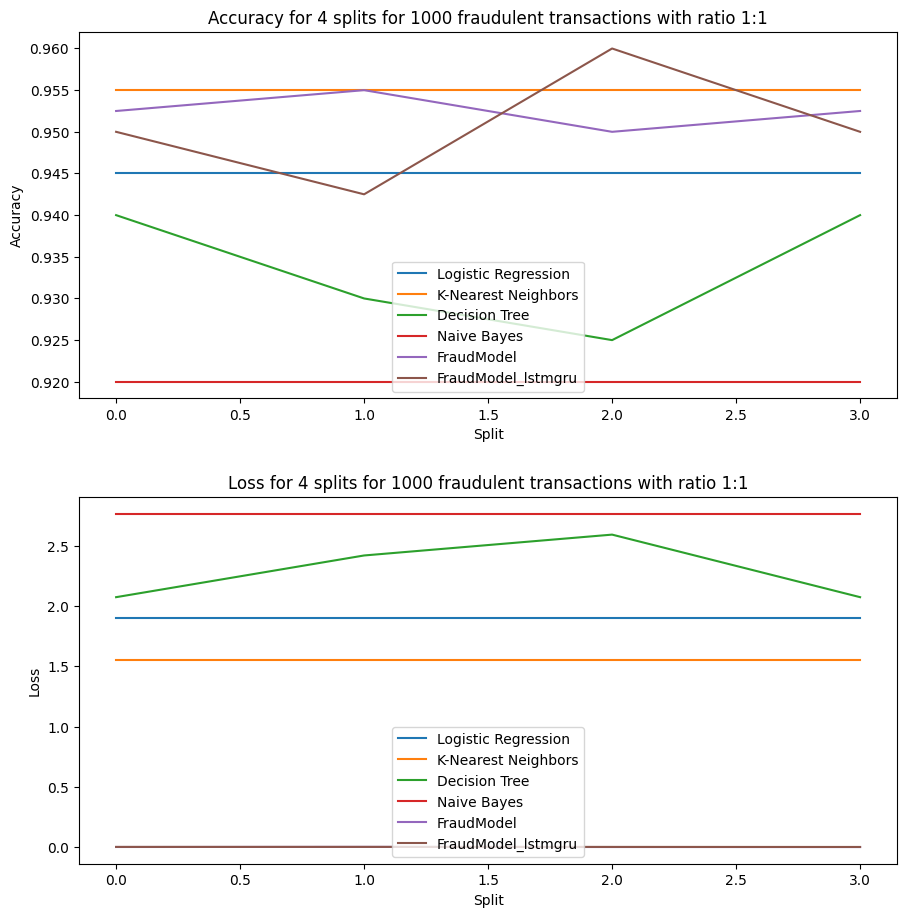

This is Split number: 1 for 1500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9550, Precision: 0.9745, Recall: 0.9303, F1-score: 0.9519, ROC-AUC: 0.9540

K-Nearest Neighbors:
Accuracy: 0.9783, Precision: 0.9757, Recall: 0.9791, F1-score: 0.9774, ROC-AUC: 0.9784

Decision Tree:
Accuracy: 0.9500, Precision: 0.9446, Recall: 0.9512, F1-score: 0.9479, ROC-AUC: 0.9501

Naive Bayes:
Accuracy: 0.9100, Precision: 0.9641, Recall: 0.8432, F1-score: 0.8996, ROC-AUC: 0.9072


***************************************************************************

For the FraudModel:
Accuracy: 0.9650, Precision: 0.9926, Recall: 0.9338, F1-score: 0.9623, ROC-AUC: 0.9909


For the FraudModel_lstmgru:
Accuracy: 0.9600, Precision: 0.9713, Recall: 0.9443, F1-score: 0.9576, ROC-AUC: 0.9918

***************************************************************************

This is Split number: 2 for 1500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9550, Precision: 

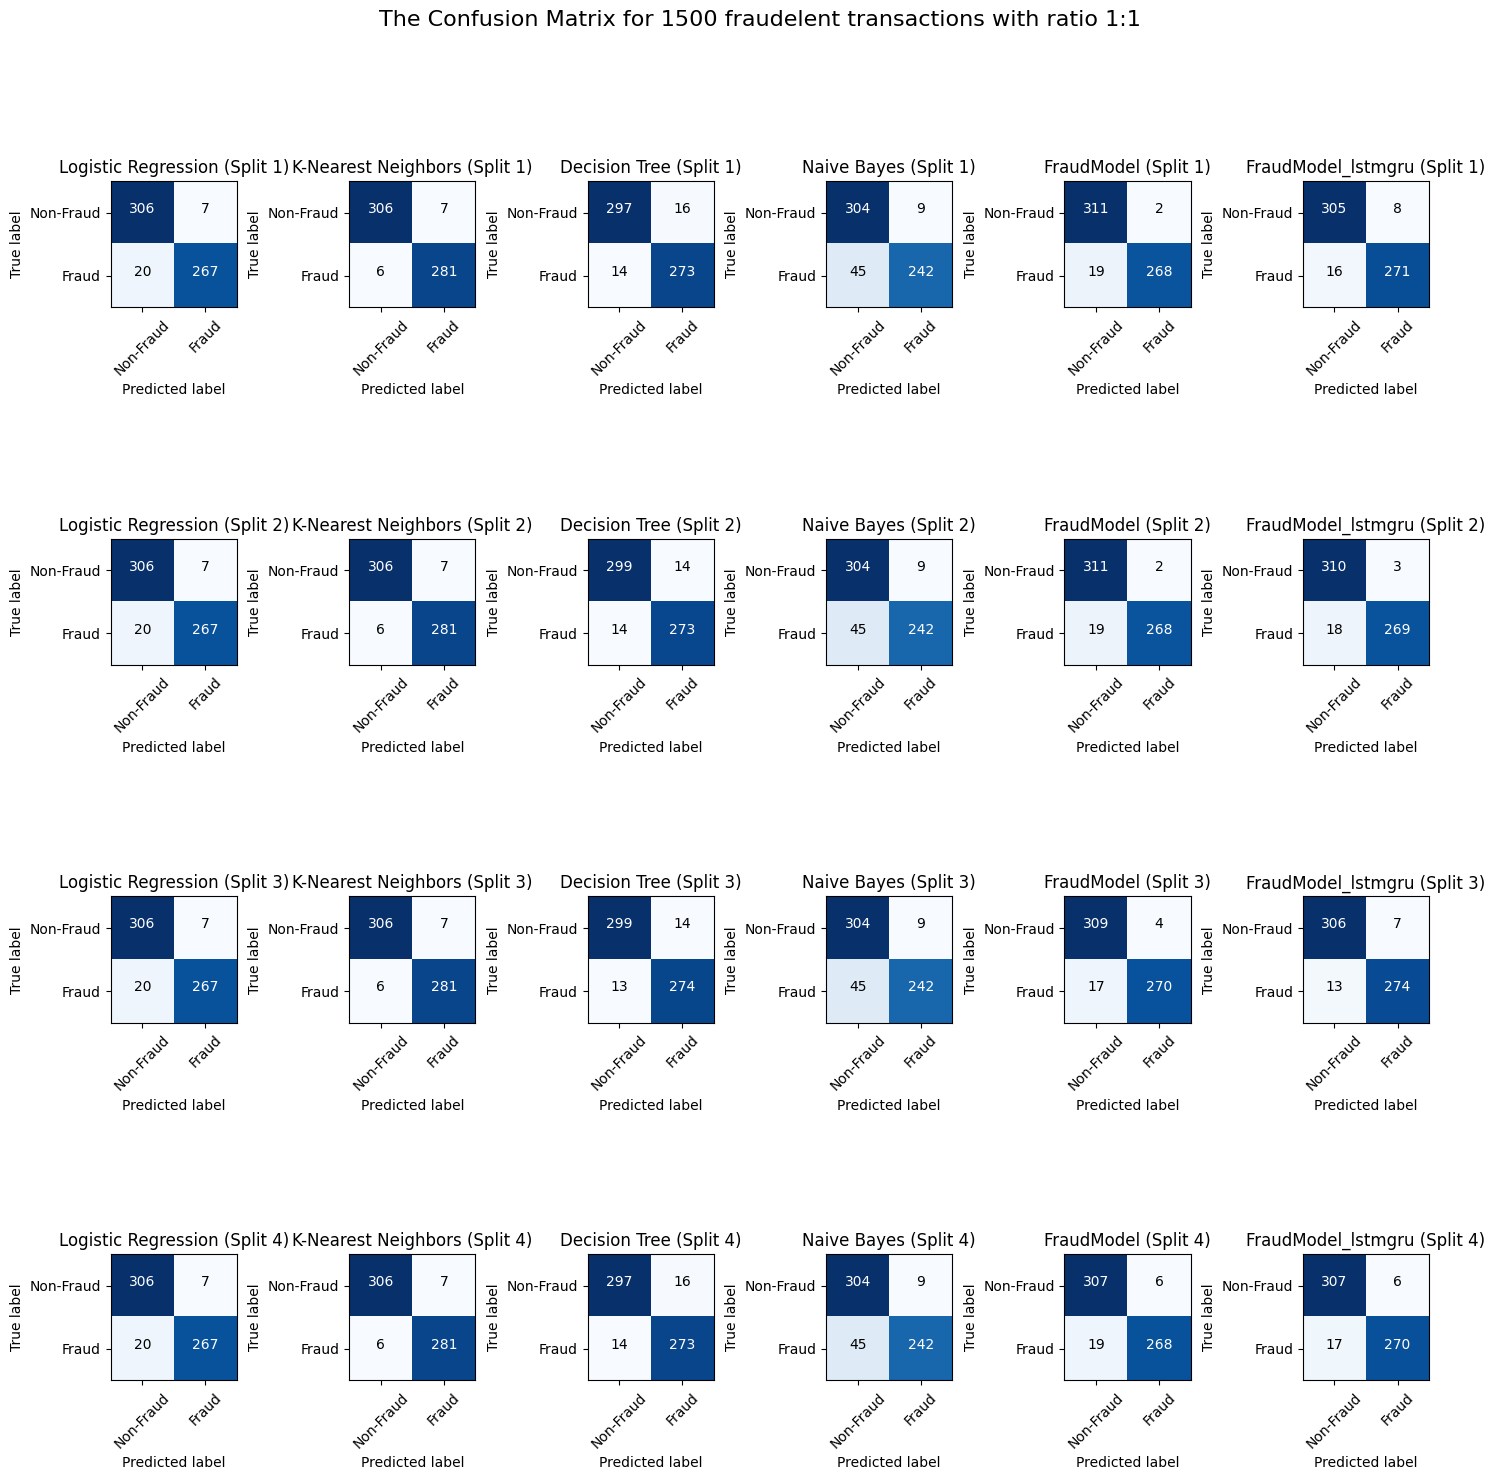

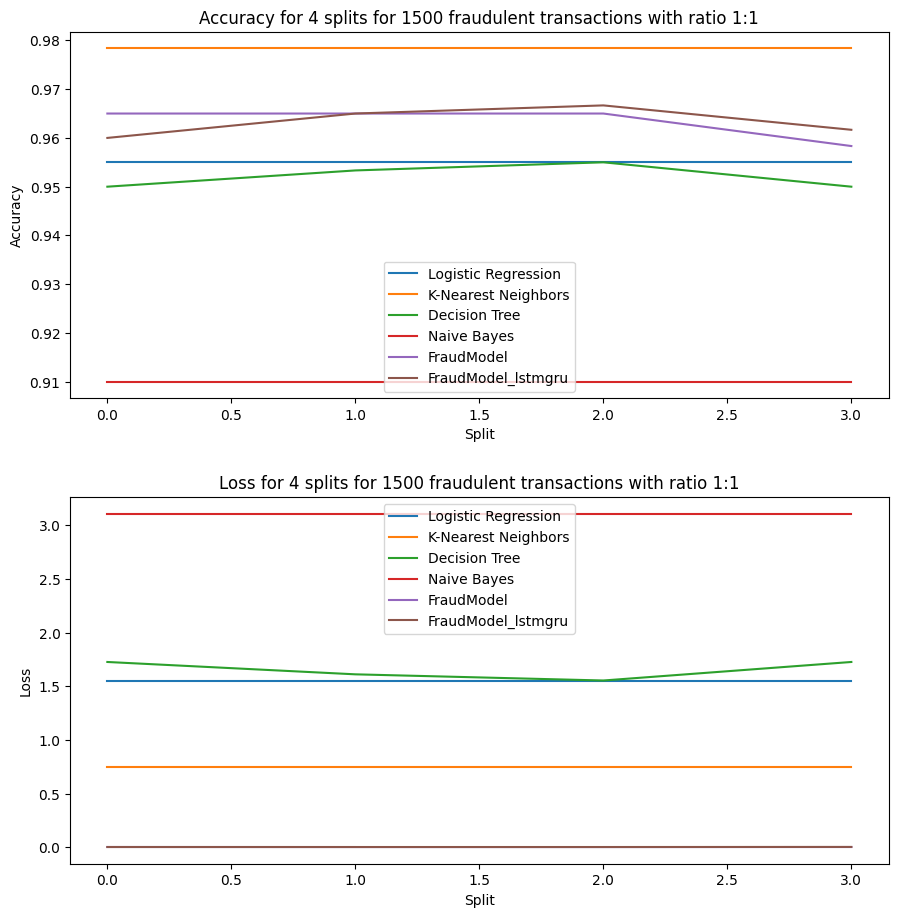

This is Split number: 1 for 2000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9575, Precision: 0.9804, Recall: 0.9286, F1-score: 0.9538, ROC-AUC: 0.9560

K-Nearest Neighbors:
Accuracy: 0.9700, Precision: 0.9538, Recall: 0.9841, F1-score: 0.9688, ROC-AUC: 0.9707

Decision Tree:
Accuracy: 0.9563, Precision: 0.9409, Recall: 0.9683, F1-score: 0.9544, ROC-AUC: 0.9569

Naive Bayes:
Accuracy: 0.9325, Precision: 0.9602, Recall: 0.8942, F1-score: 0.9260, ROC-AUC: 0.9305


***************************************************************************

For the FraudModel:
Accuracy: 0.9625, Precision: 0.9888, Recall: 0.9312, F1-score: 0.9591, ROC-AUC: 0.9918


For the FraudModel_lstmgru:
Accuracy: 0.9637, Precision: 0.9580, Recall: 0.9656, F1-score: 0.9618, ROC-AUC: 0.9936

***************************************************************************

This is Split number: 2 for 2000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9575, Precision: 

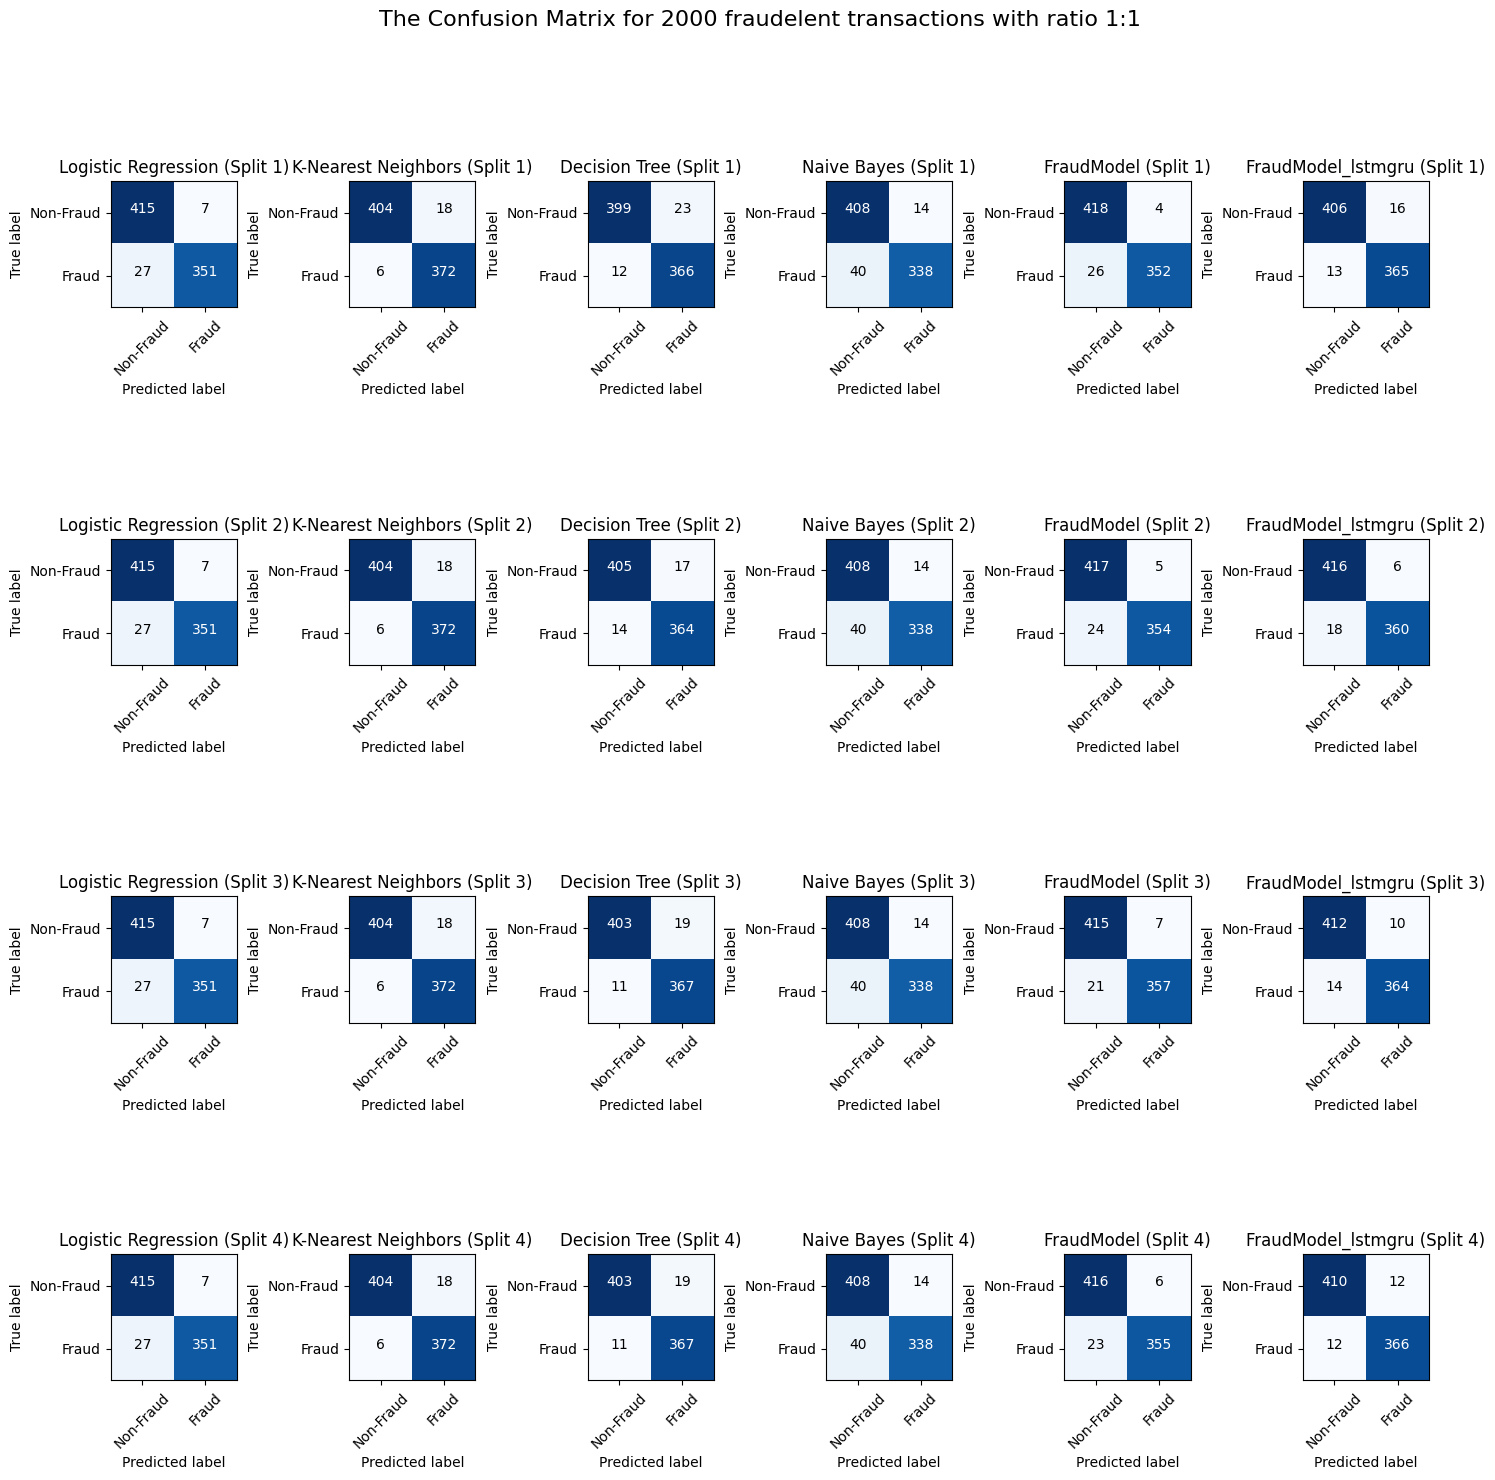

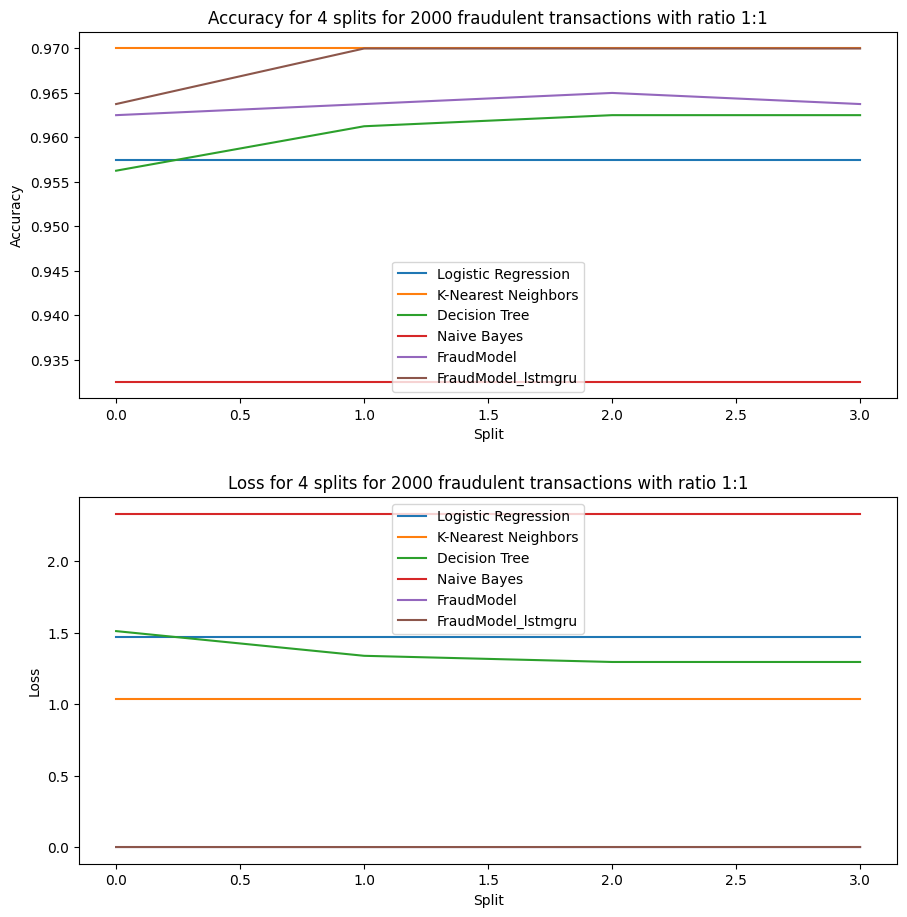

This is Split number: 1 for 2500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9600, Precision: 0.9832, Recall: 0.9360, F1-score: 0.9590, ROC-AUC: 0.9600

K-Nearest Neighbors:
Accuracy: 0.9730, Precision: 0.9574, Recall: 0.9900, F1-score: 0.9735, ROC-AUC: 0.9730

Decision Tree:
Accuracy: 0.9640, Precision: 0.9677, Recall: 0.9600, F1-score: 0.9639, ROC-AUC: 0.9640

Naive Bayes:
Accuracy: 0.9330, Precision: 0.9800, Recall: 0.8840, F1-score: 0.9295, ROC-AUC: 0.9330


***************************************************************************

For the FraudModel:
Accuracy: 0.9720, Precision: 0.9958, Recall: 0.9480, F1-score: 0.9713, ROC-AUC: 0.9967


For the FraudModel_lstmgru:
Accuracy: 0.9780, Precision: 0.9898, Recall: 0.9660, F1-score: 0.9777, ROC-AUC: 0.9970

***************************************************************************

This is Split number: 2 for 2500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9600, Precision: 

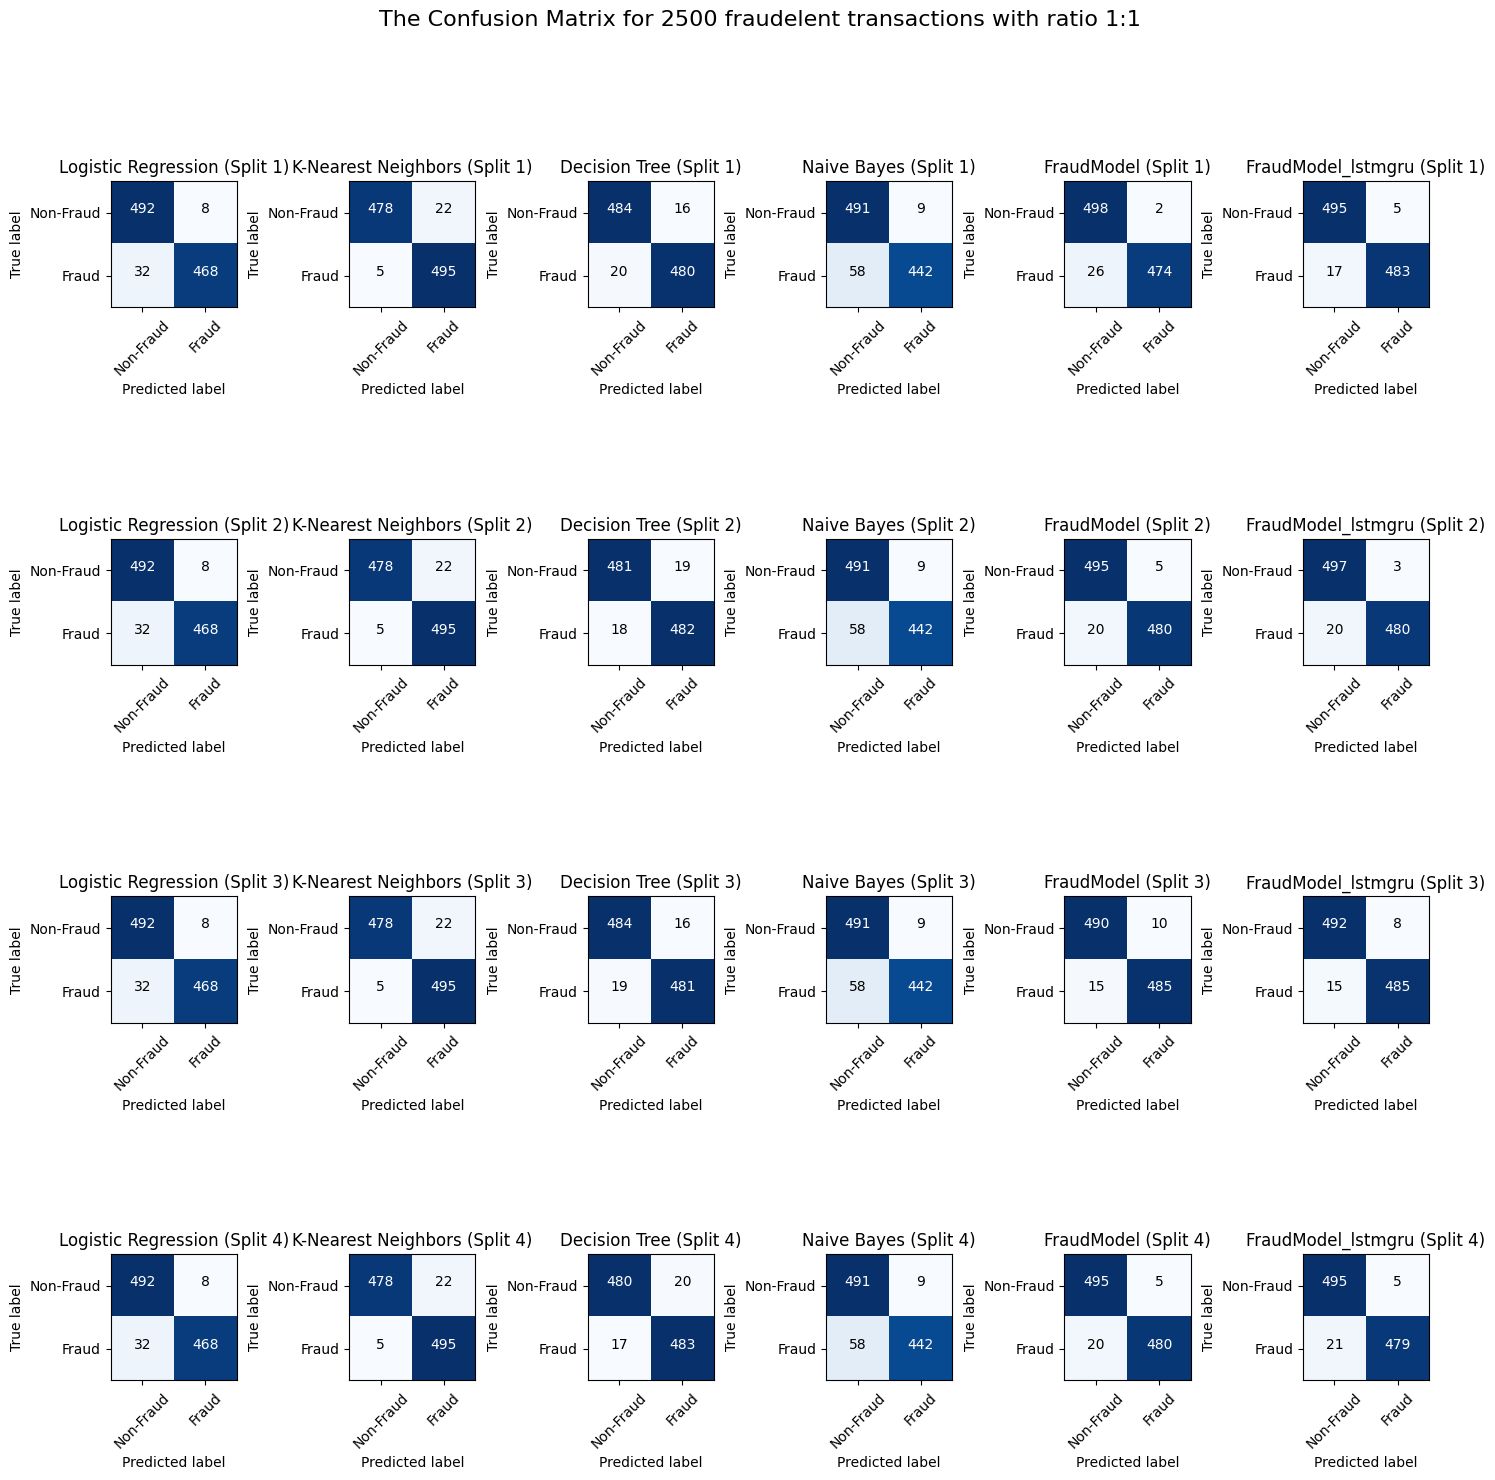

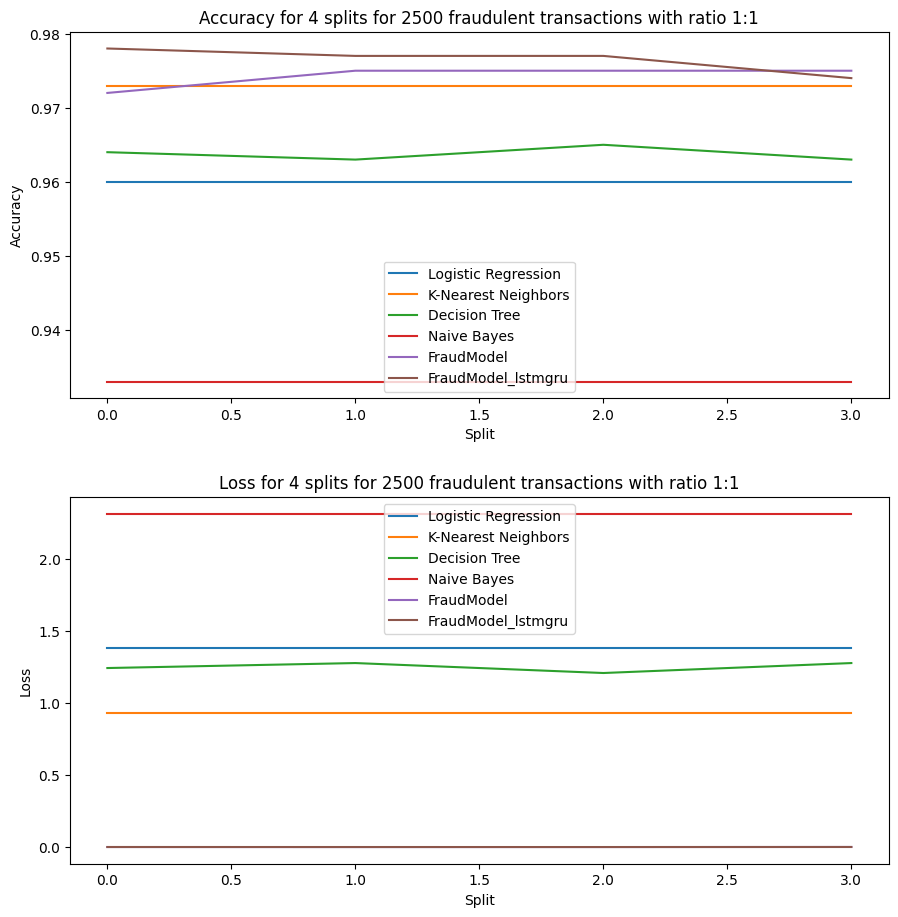

This is Split number: 1 for 3000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9442, Precision: 0.9727, Recall: 0.9114, F1-score: 0.9411, ROC-AUC: 0.9435

K-Nearest Neighbors:
Accuracy: 0.9800, Precision: 0.9699, Recall: 0.9898, F1-score: 0.9798, ROC-AUC: 0.9802

Decision Tree:
Accuracy: 0.9658, Precision: 0.9520, Recall: 0.9796, F1-score: 0.9656, ROC-AUC: 0.9661

Naive Bayes:
Accuracy: 0.9117, Precision: 0.9688, Recall: 0.8467, F1-score: 0.9036, ROC-AUC: 0.9103


***************************************************************************

For the FraudModel:
Accuracy: 0.9742, Precision: 0.9843, Recall: 0.9625, F1-score: 0.9733, ROC-AUC: 0.9940


For the FraudModel_lstmgru:
Accuracy: 0.9725, Precision: 0.9894, Recall: 0.9540, F1-score: 0.9714, ROC-AUC: 0.9959

***************************************************************************

This is Split number: 2 for 3000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9442, Precision: 

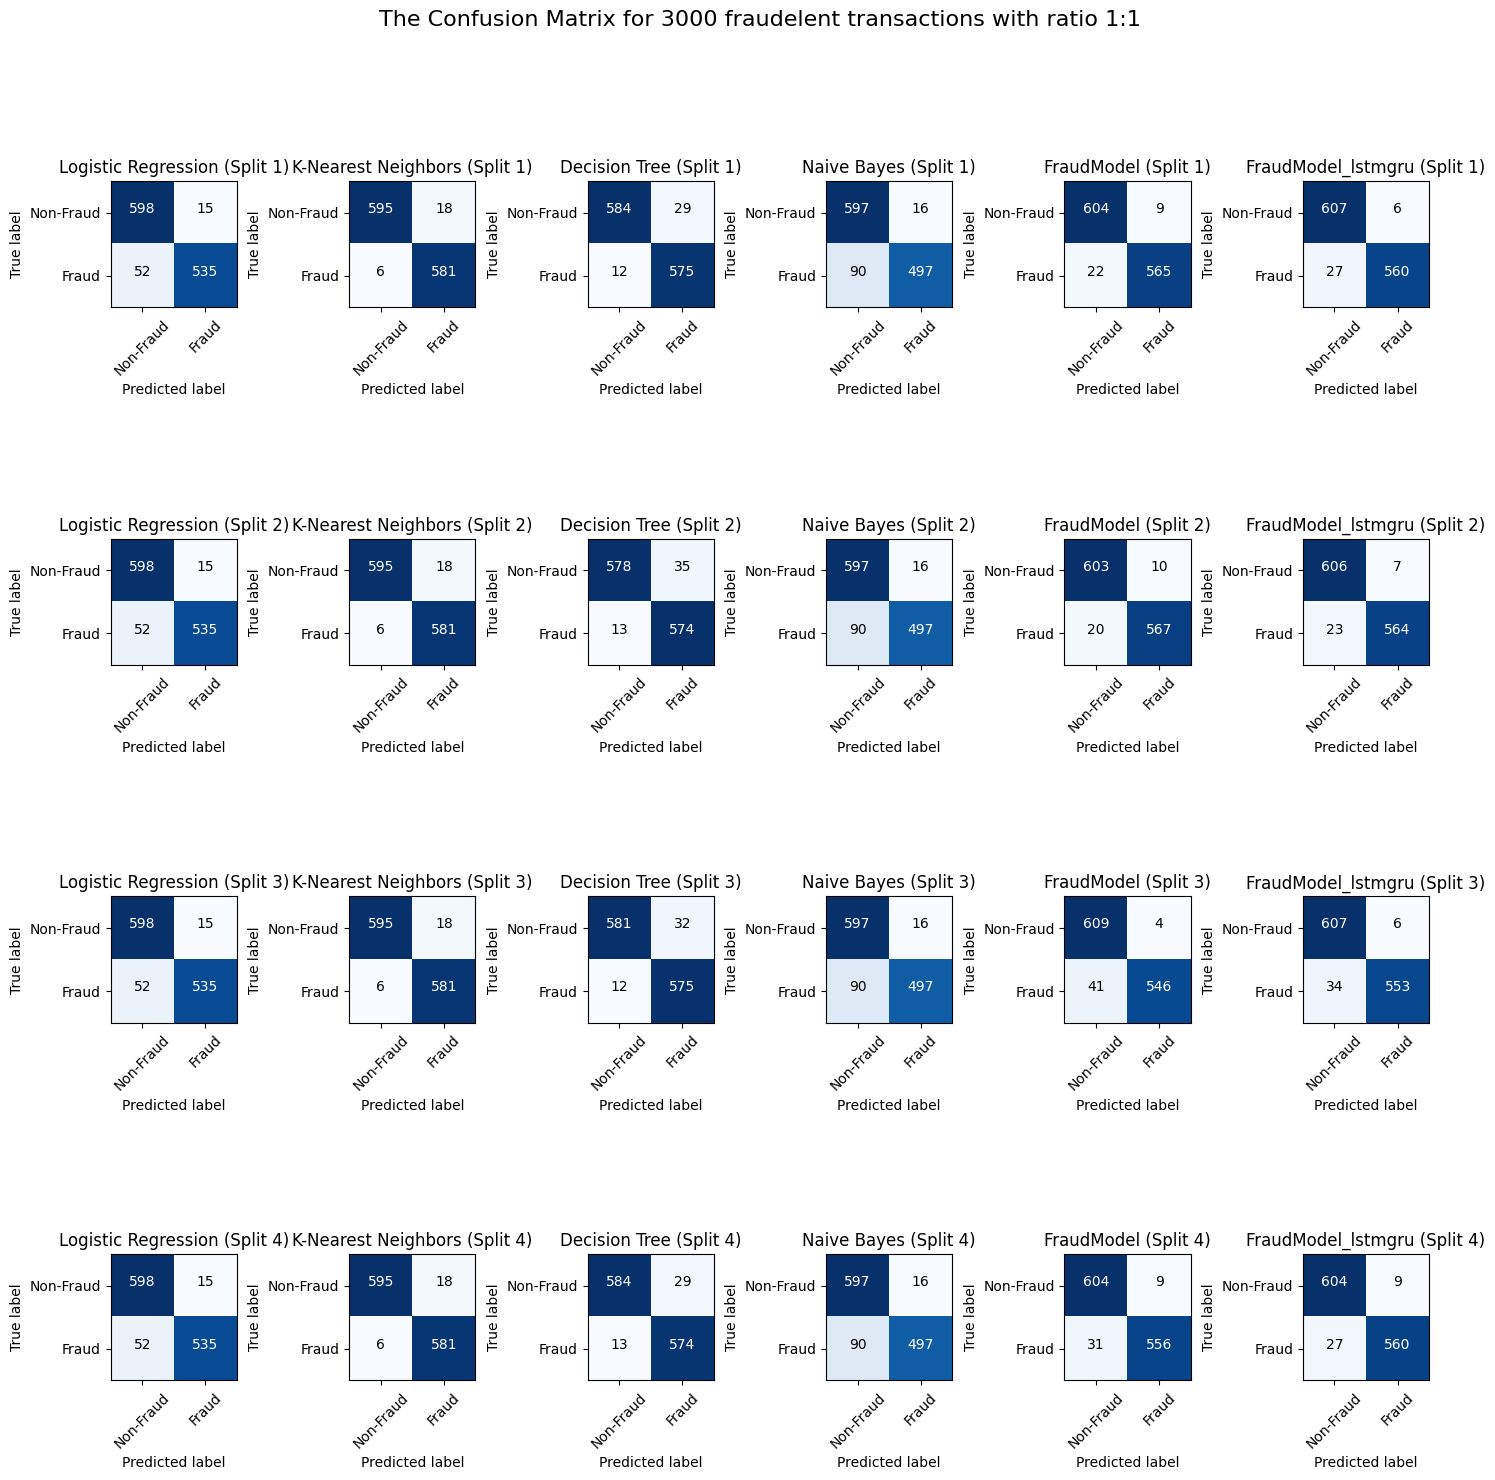

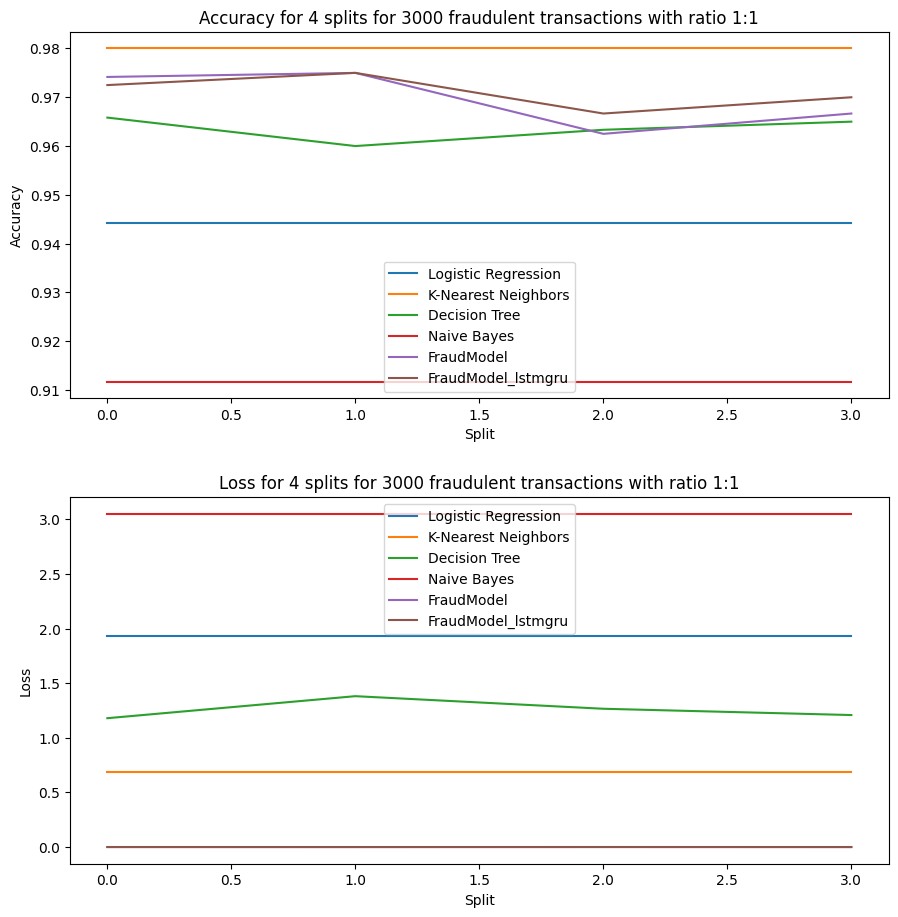

This is Split number: 1 for 3500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9550, Precision: 0.9815, Recall: 0.9260, F1-score: 0.9529, ROC-AUC: 0.9546

K-Nearest Neighbors:
Accuracy: 0.9800, Precision: 0.9648, Recall: 0.9956, F1-score: 0.9800, ROC-AUC: 0.9802

Decision Tree:
Accuracy: 0.9629, Precision: 0.9531, Recall: 0.9724, F1-score: 0.9626, ROC-AUC: 0.9630

Naive Bayes:
Accuracy: 0.9243, Precision: 0.9694, Recall: 0.8737, F1-score: 0.9191, ROC-AUC: 0.9235


***************************************************************************

For the FraudModel:
Accuracy: 0.9736, Precision: 0.9808, Recall: 0.9652, F1-score: 0.9729, ROC-AUC: 0.9971


For the FraudModel_lstmgru:
Accuracy: 0.9779, Precision: 0.9940, Recall: 0.9608, F1-score: 0.9771, ROC-AUC: 0.9980

***************************************************************************

This is Split number: 2 for 3500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9550, Precision: 

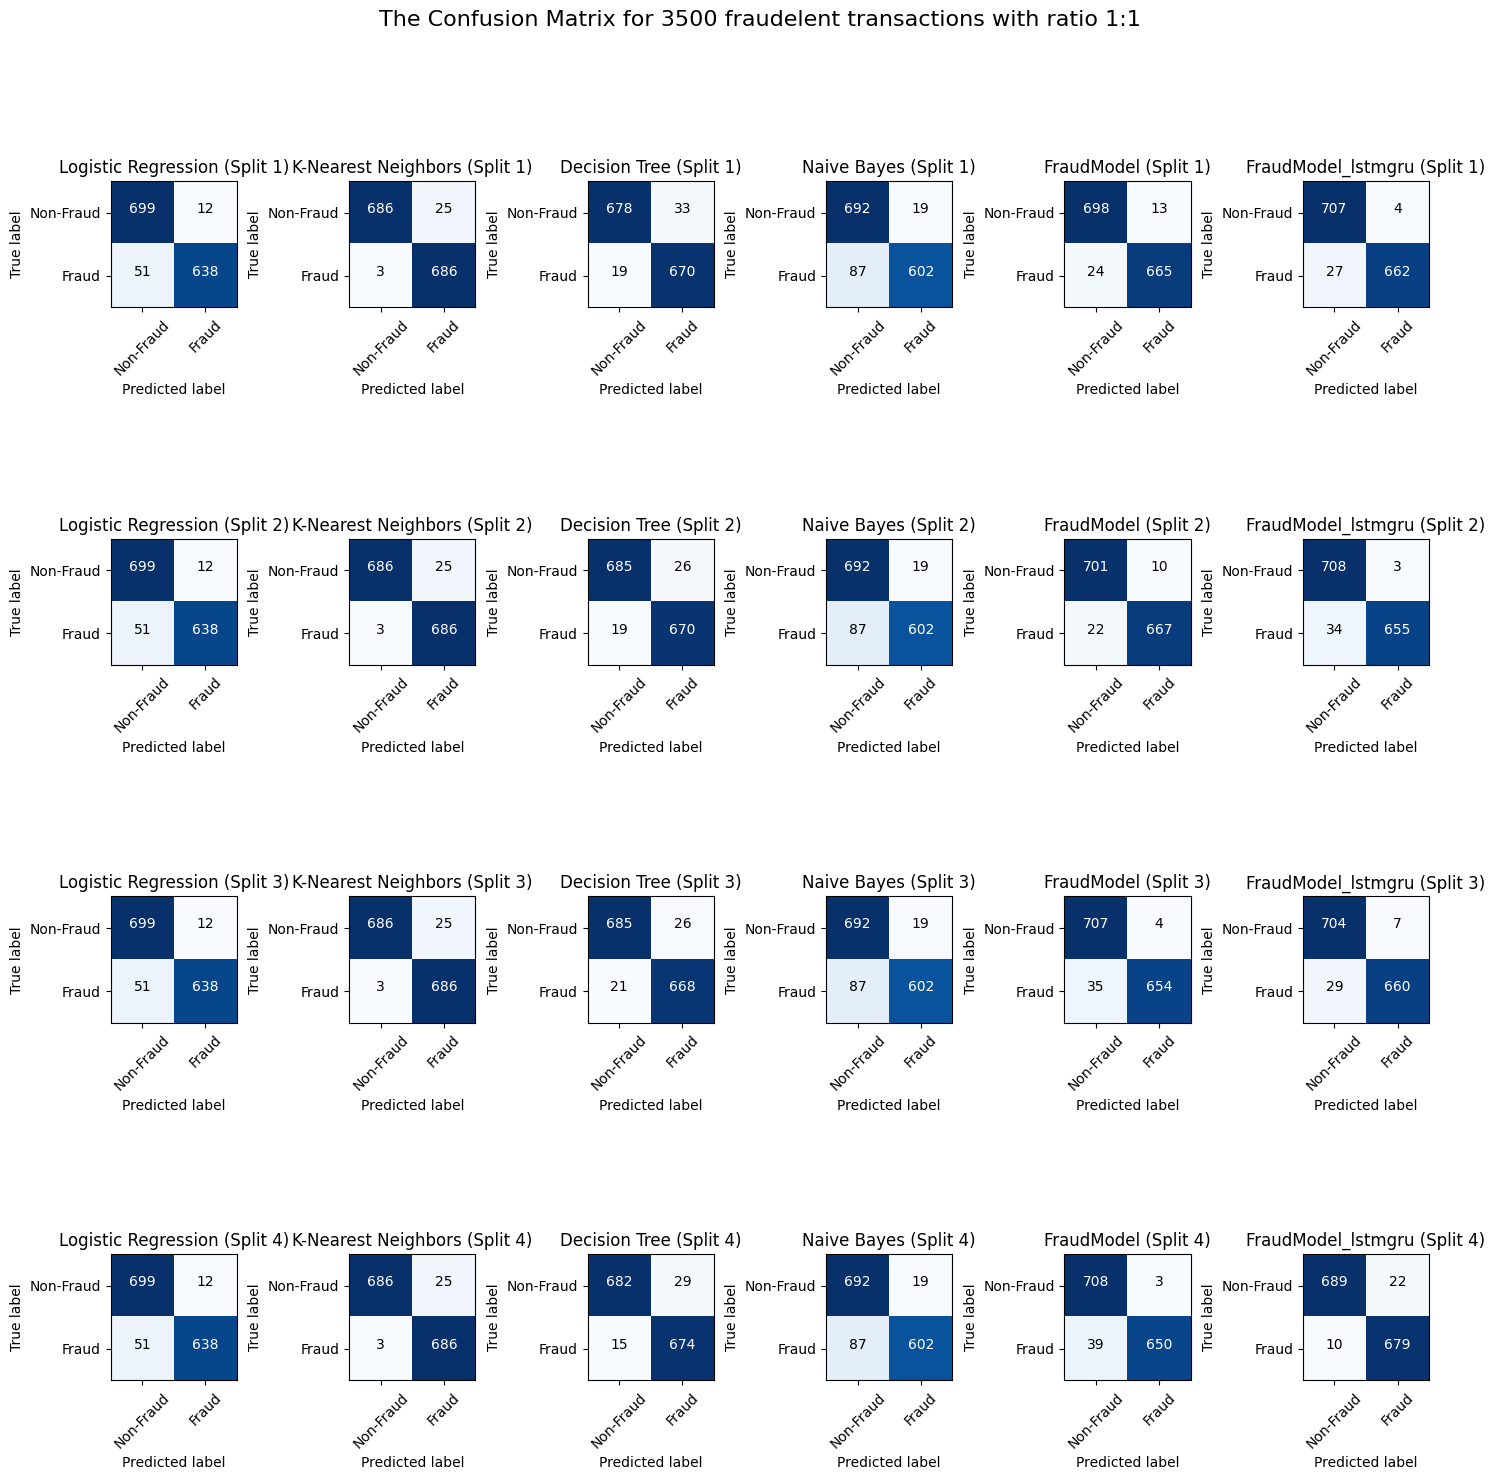

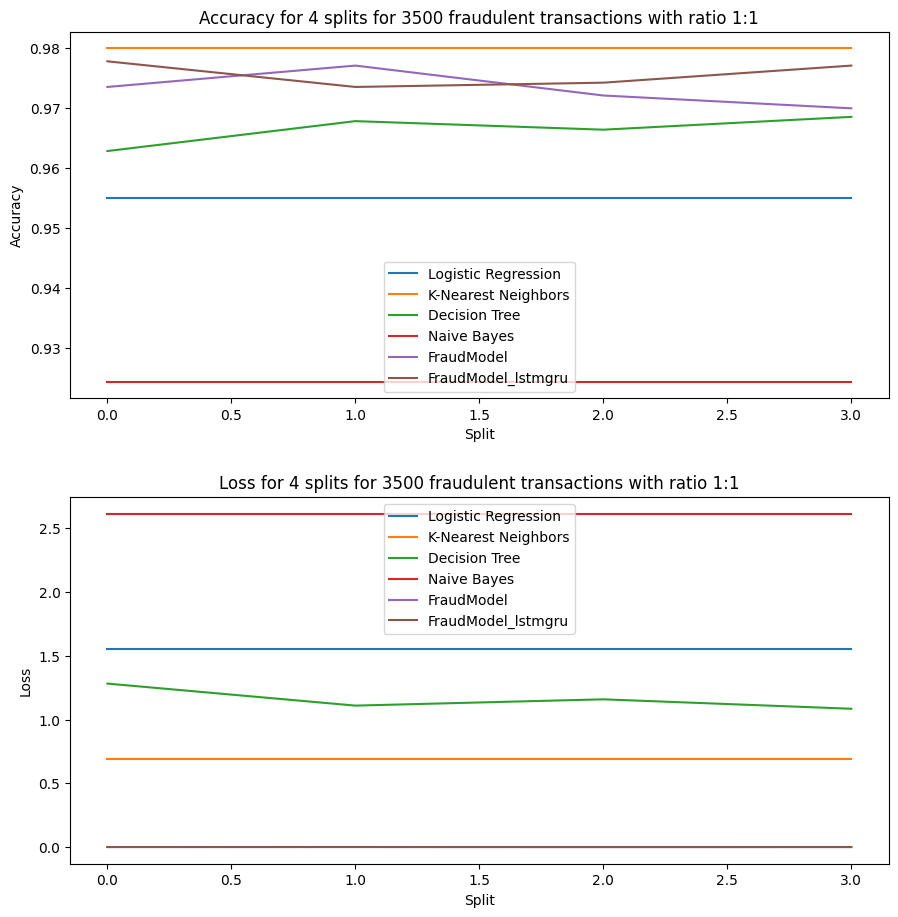

This is Split number: 1 for 4000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9431, Precision: 0.9669, Recall: 0.9171, F1-score: 0.9413, ROC-AUC: 0.9430

K-Nearest Neighbors:
Accuracy: 0.9794, Precision: 0.9602, Recall: 1.0000, F1-score: 0.9797, ROC-AUC: 0.9795

Decision Tree:
Accuracy: 0.9656, Precision: 0.9602, Recall: 0.9711, F1-score: 0.9656, ROC-AUC: 0.9657

Naive Bayes:
Accuracy: 0.9187, Precision: 0.9677, Recall: 0.8656, F1-score: 0.9138, ROC-AUC: 0.9185


***************************************************************************

For the FraudModel:
Accuracy: 0.9706, Precision: 0.9832, Recall: 0.9573, F1-score: 0.9701, ROC-AUC: 0.9966


For the FraudModel_lstmgru:
Accuracy: 0.9725, Precision: 0.9896, Recall: 0.9548, F1-score: 0.9719, ROC-AUC: 0.9984

***************************************************************************

This is Split number: 2 for 4000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9431, Precision: 

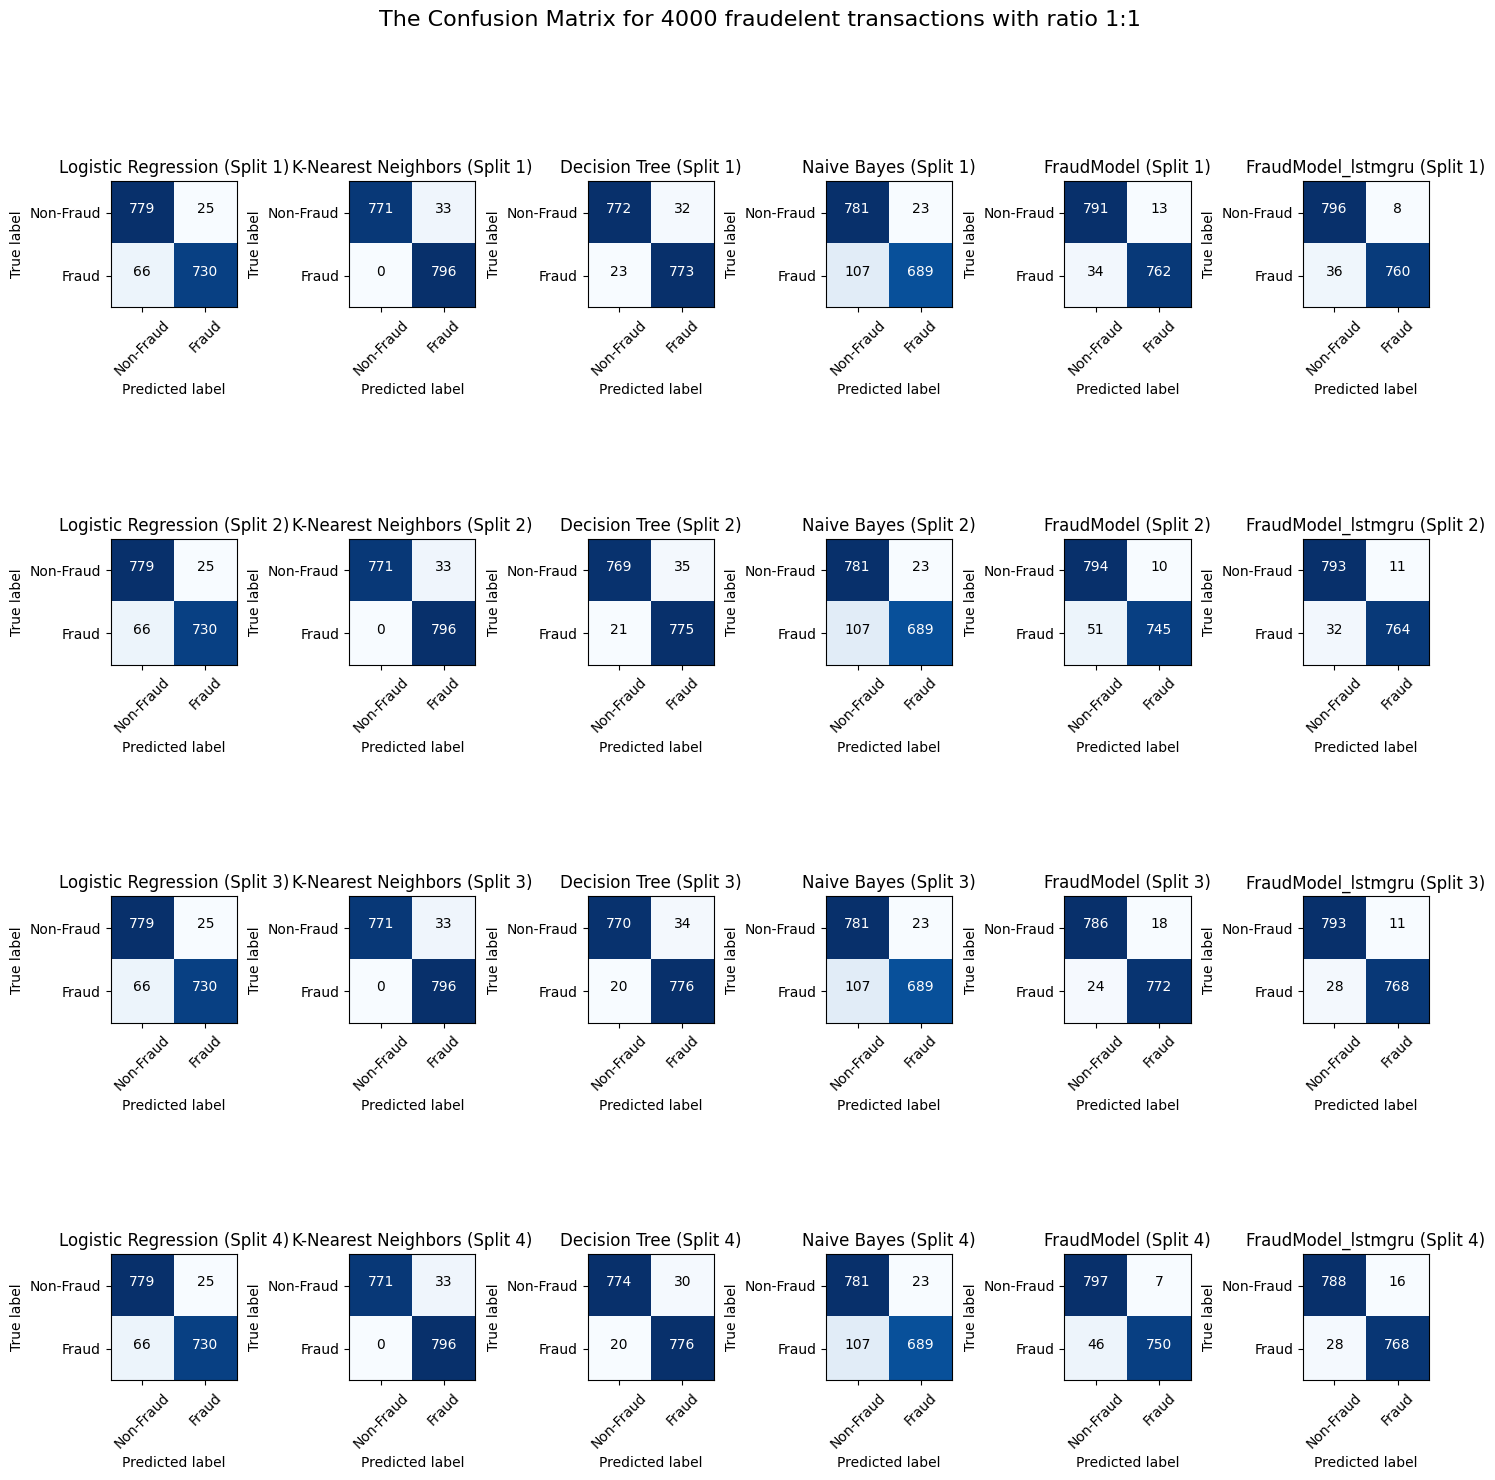

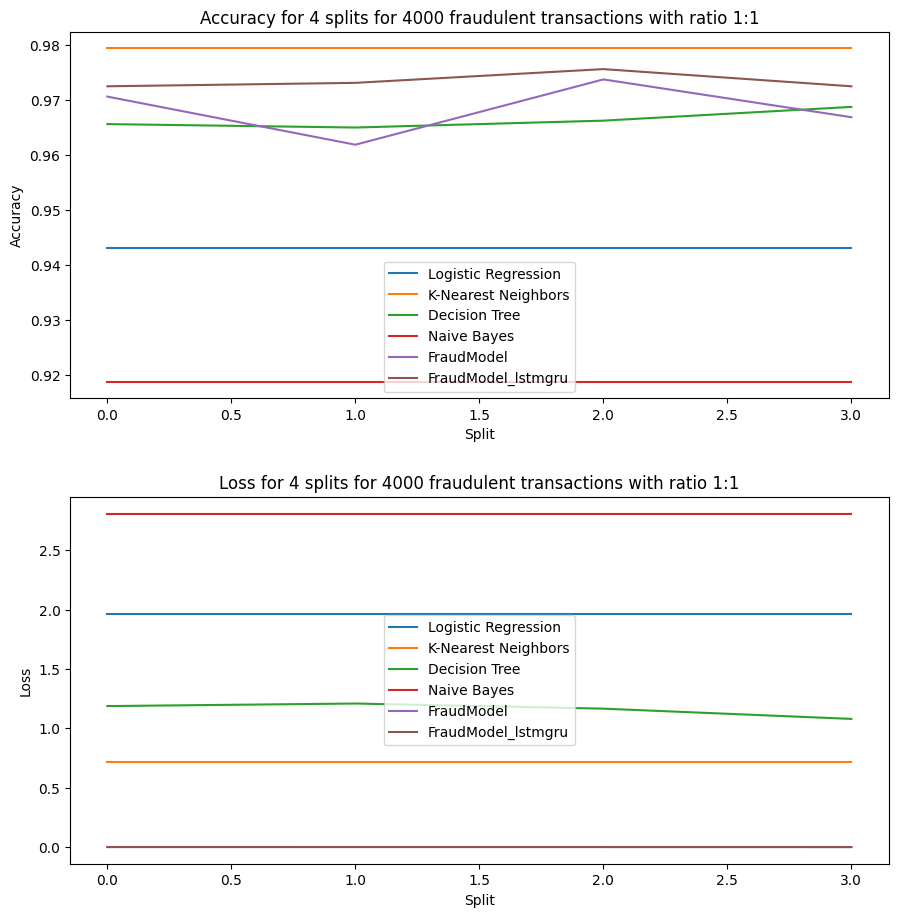

This is Split number: 1 for 4500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9400, Precision: 0.9764, Recall: 0.9039, F1-score: 0.9388, ROC-AUC: 0.9407

K-Nearest Neighbors:
Accuracy: 0.9822, Precision: 0.9712, Recall: 0.9945, F1-score: 0.9827, ROC-AUC: 0.9820

Decision Tree:
Accuracy: 0.9606, Precision: 0.9607, Recall: 0.9618, F1-score: 0.9613, ROC-AUC: 0.9605

Naive Bayes:
Accuracy: 0.9022, Precision: 0.9719, Recall: 0.8319, F1-score: 0.8965, ROC-AUC: 0.9035


***************************************************************************

For the FraudModel:
Accuracy: 0.9789, Precision: 0.9922, Recall: 0.9662, F1-score: 0.9790, ROC-AUC: 0.9970


For the FraudModel_lstmgru:
Accuracy: 0.9756, Precision: 0.9932, Recall: 0.9585, F1-score: 0.9756, ROC-AUC: 0.9971

***************************************************************************

This is Split number: 2 for 4500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9400, Precision: 

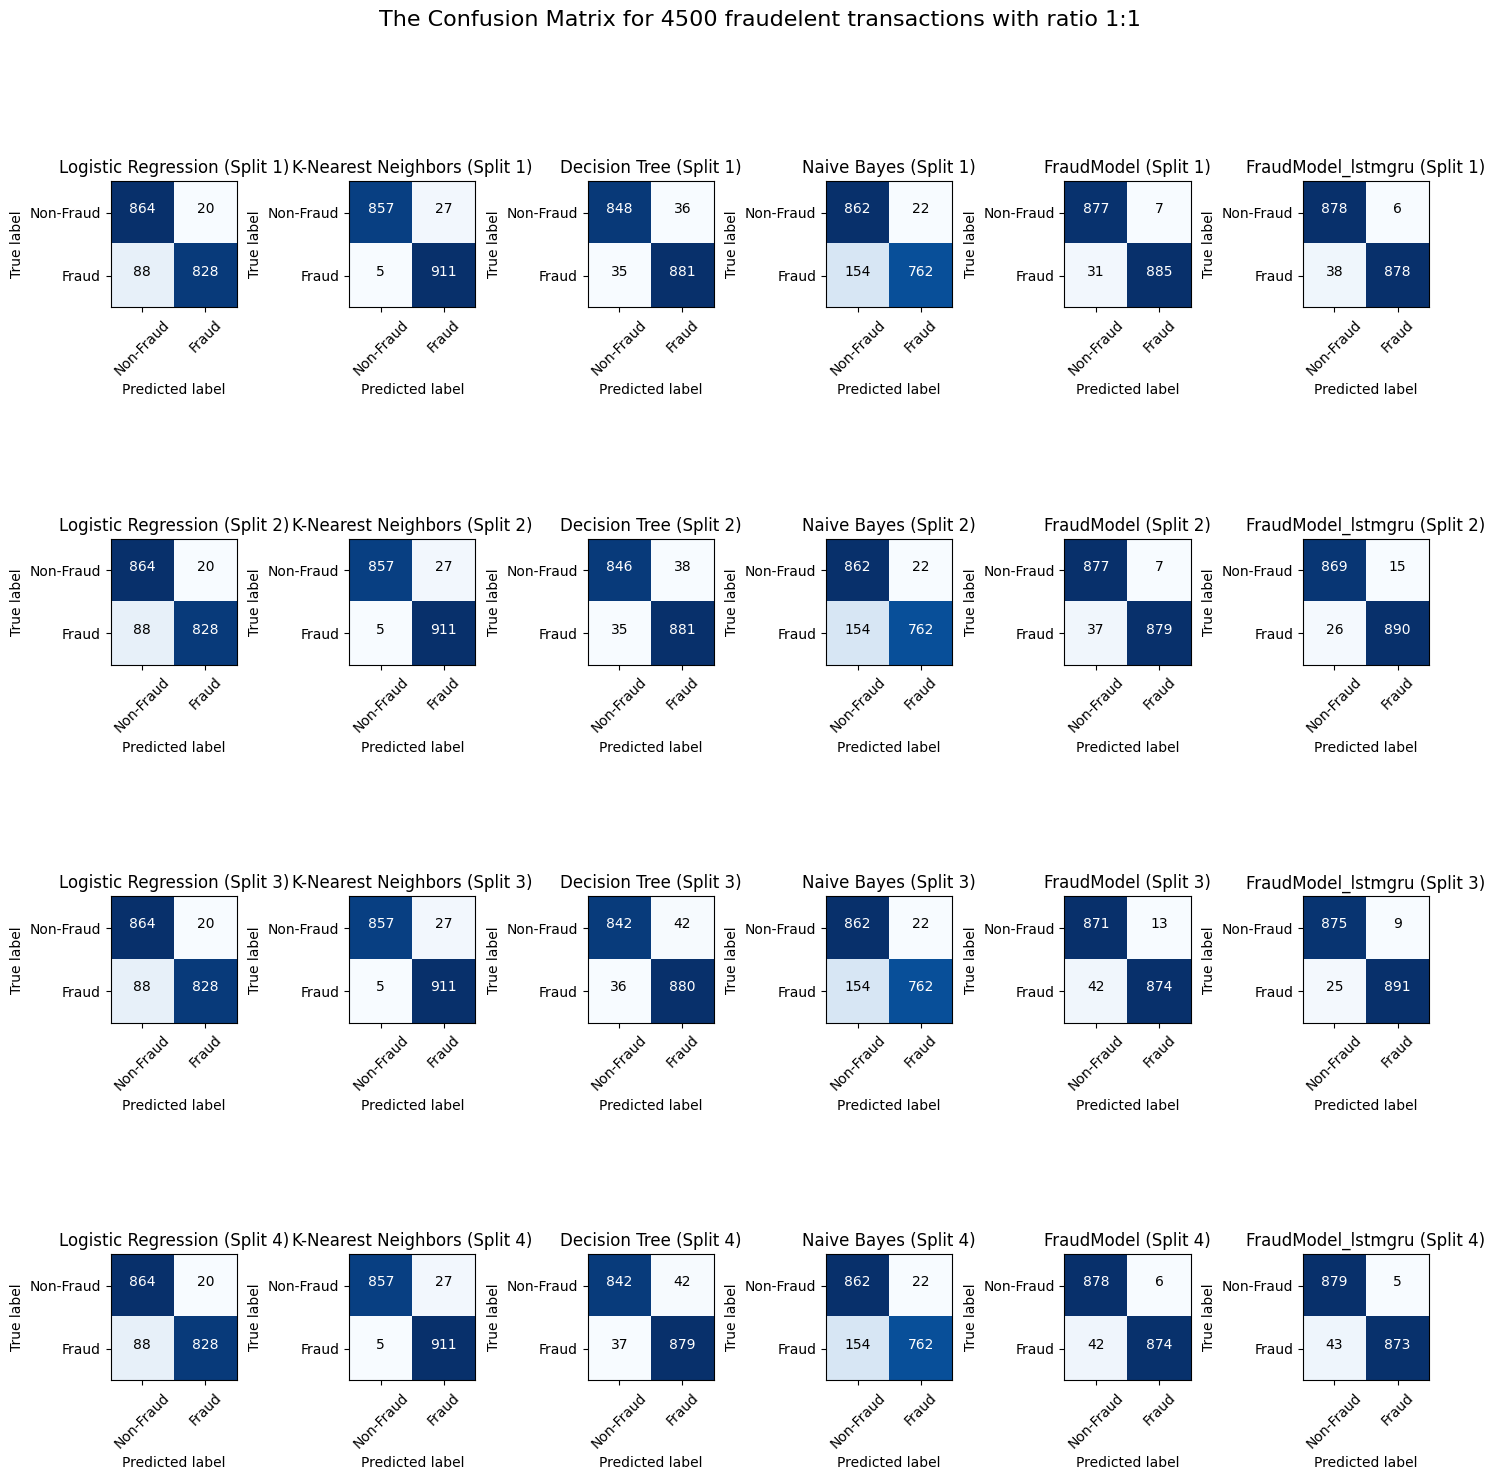

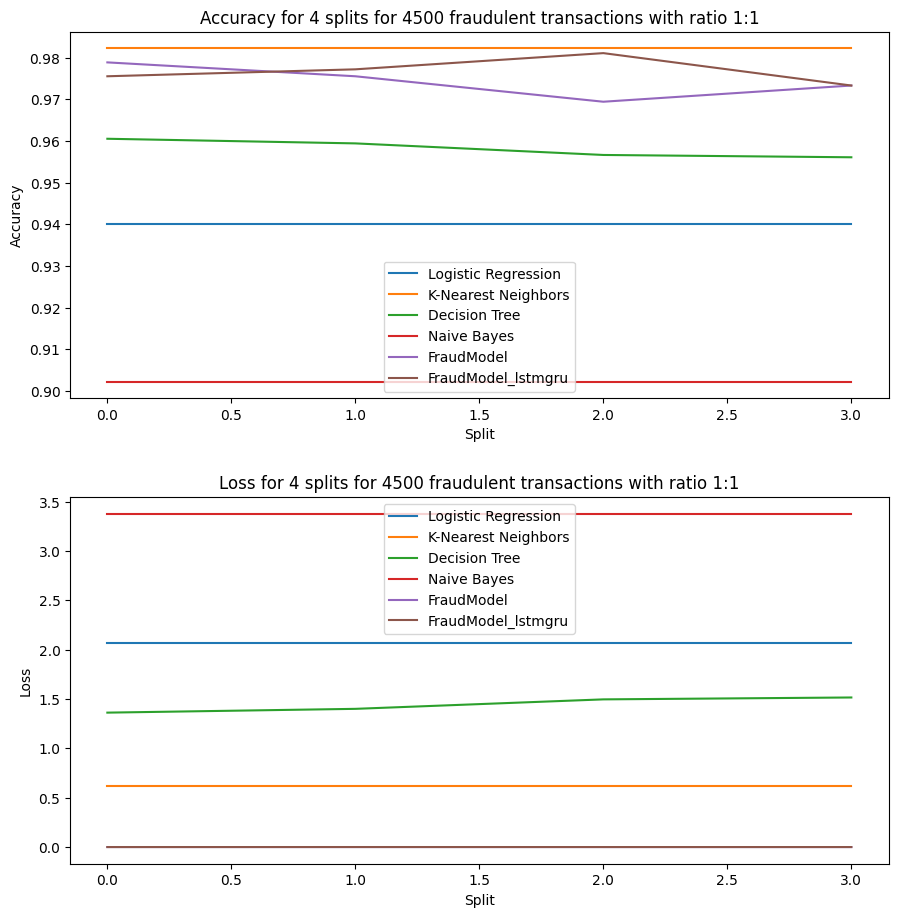

This is Split number: 1 for 5000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9340, Precision: 0.9602, Recall: 0.9038, F1-score: 0.9312, ROC-AUC: 0.9336

K-Nearest Neighbors:
Accuracy: 0.9775, Precision: 0.9573, Recall: 0.9990, F1-score: 0.9777, ROC-AUC: 0.9778

Decision Tree:
Accuracy: 0.9565, Precision: 0.9447, Recall: 0.9686, F1-score: 0.9565, ROC-AUC: 0.9566

Naive Bayes:
Accuracy: 0.8930, Precision: 0.9542, Recall: 0.8229, F1-score: 0.8837, ROC-AUC: 0.8922


***************************************************************************

For the FraudModel:
Accuracy: 0.9745, Precision: 0.9718, Recall: 0.9767, F1-score: 0.9743, ROC-AUC: 0.9973


For the FraudModel_lstmgru:
Accuracy: 0.9750, Precision: 0.9747, Recall: 0.9747, F1-score: 0.9747, ROC-AUC: 0.9976

***************************************************************************

This is Split number: 2 for 5000 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9340, Precision: 

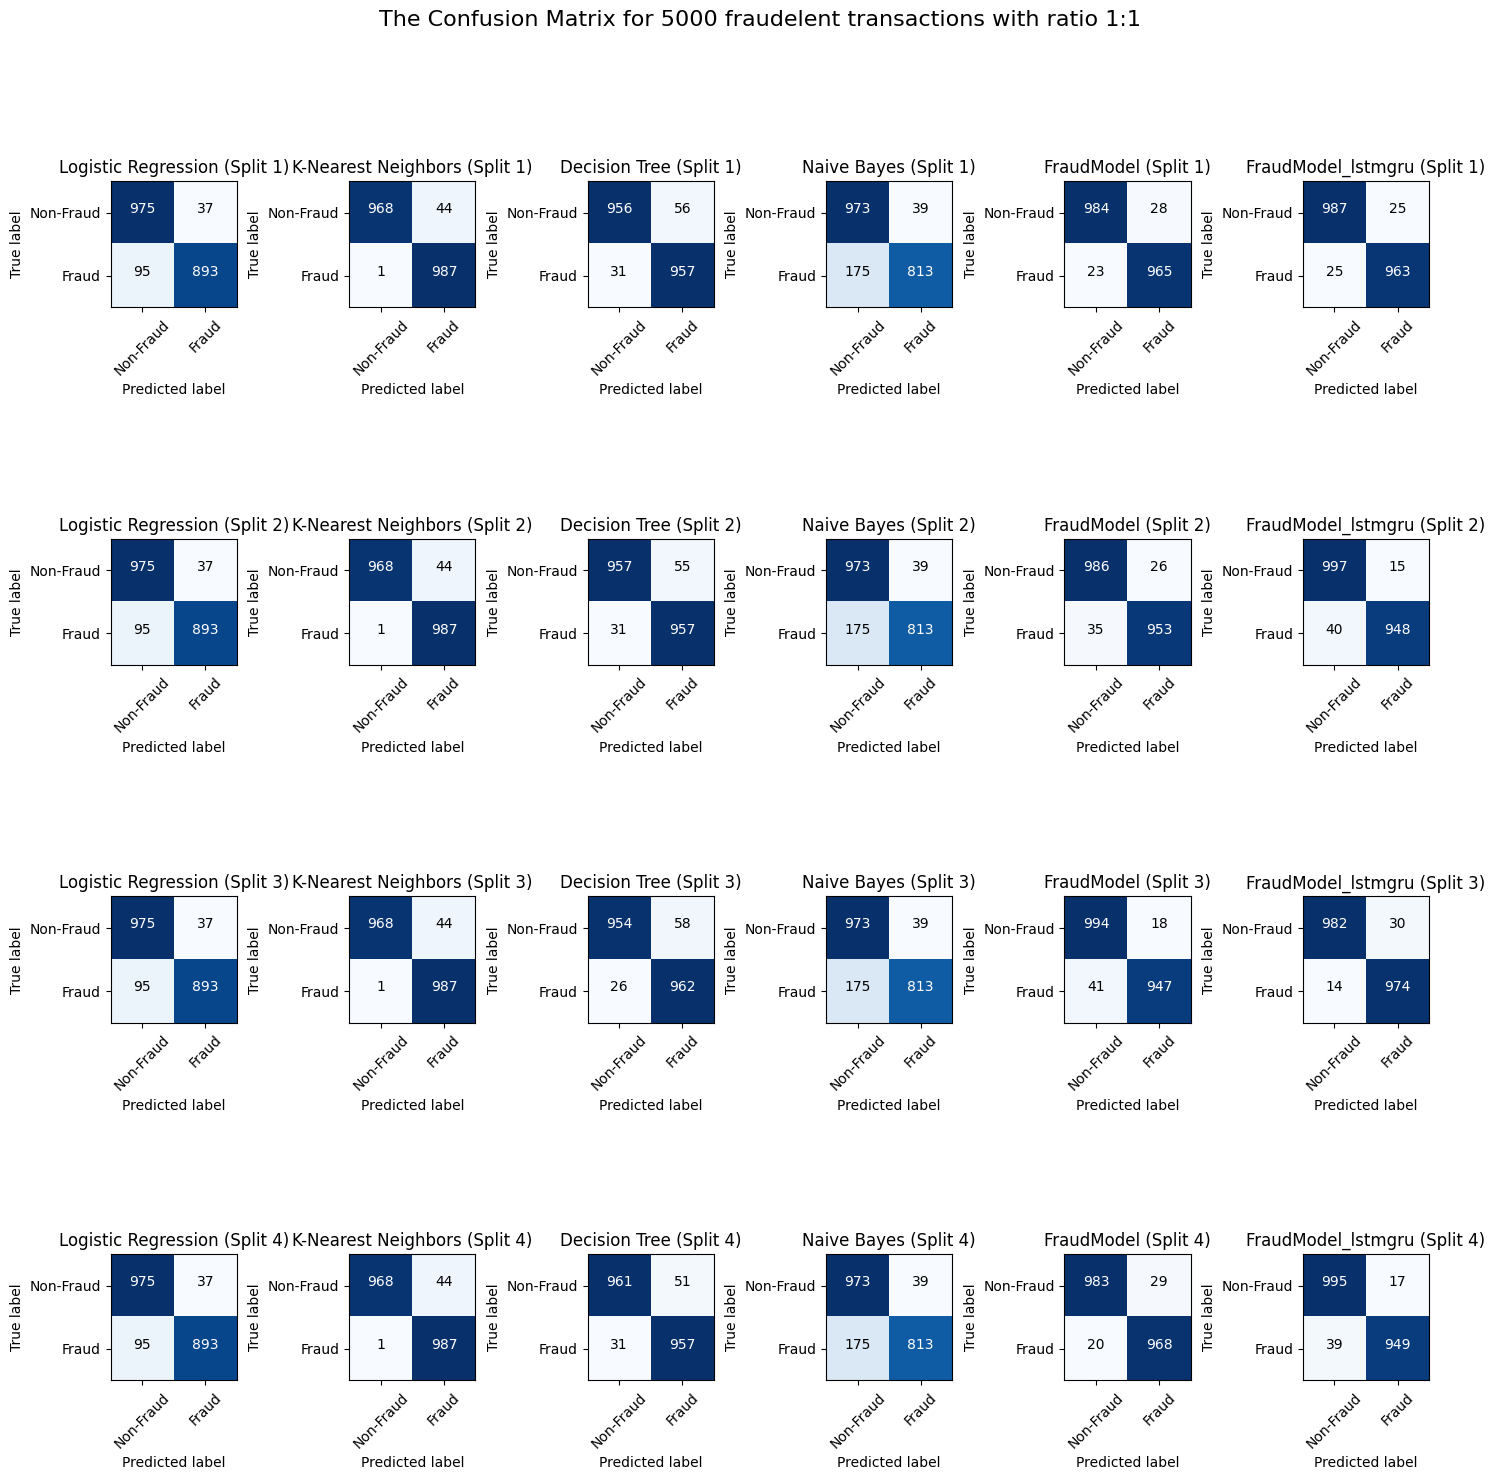

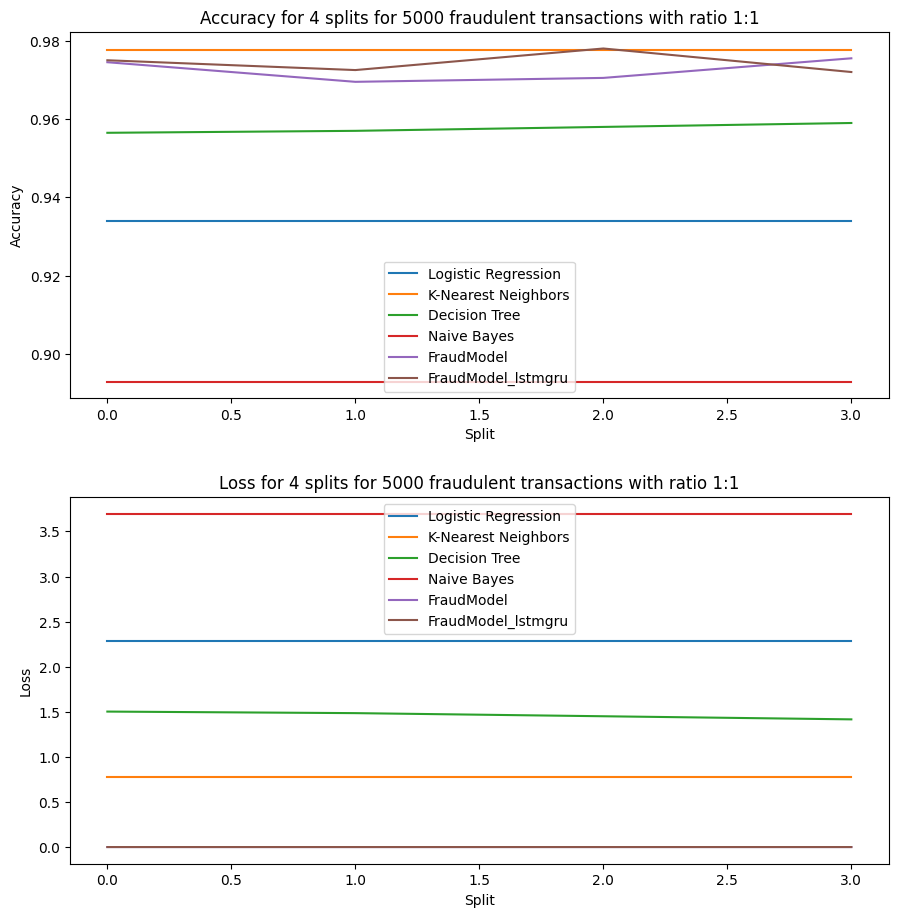

This is Split number: 1 for 5500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9368, Precision: 0.9695, Recall: 0.9011, F1-score: 0.9340, ROC-AUC: 0.9366

K-Nearest Neighbors:
Accuracy: 0.9855, Precision: 0.9741, Recall: 0.9973, F1-score: 0.9855, ROC-AUC: 0.9855

Decision Tree:
Accuracy: 0.9691, Precision: 0.9596, Recall: 0.9789, F1-score: 0.9692, ROC-AUC: 0.9692

Naive Bayes:
Accuracy: 0.8964, Precision: 0.9737, Recall: 0.8132, F1-score: 0.8862, ROC-AUC: 0.8958


***************************************************************************

For the FraudModel:
Accuracy: 0.9655, Precision: 0.9857, Recall: 0.9441, F1-score: 0.9645, ROC-AUC: 0.9973


For the FraudModel_lstmgru:
Accuracy: 0.9718, Precision: 0.9868, Recall: 0.9560, F1-score: 0.9712, ROC-AUC: 0.9981

***************************************************************************

This is Split number: 2 for 5500 fraudelent transactions with ratio 1:1


Logistic Regression:
Accuracy: 0.9368, Precision: 

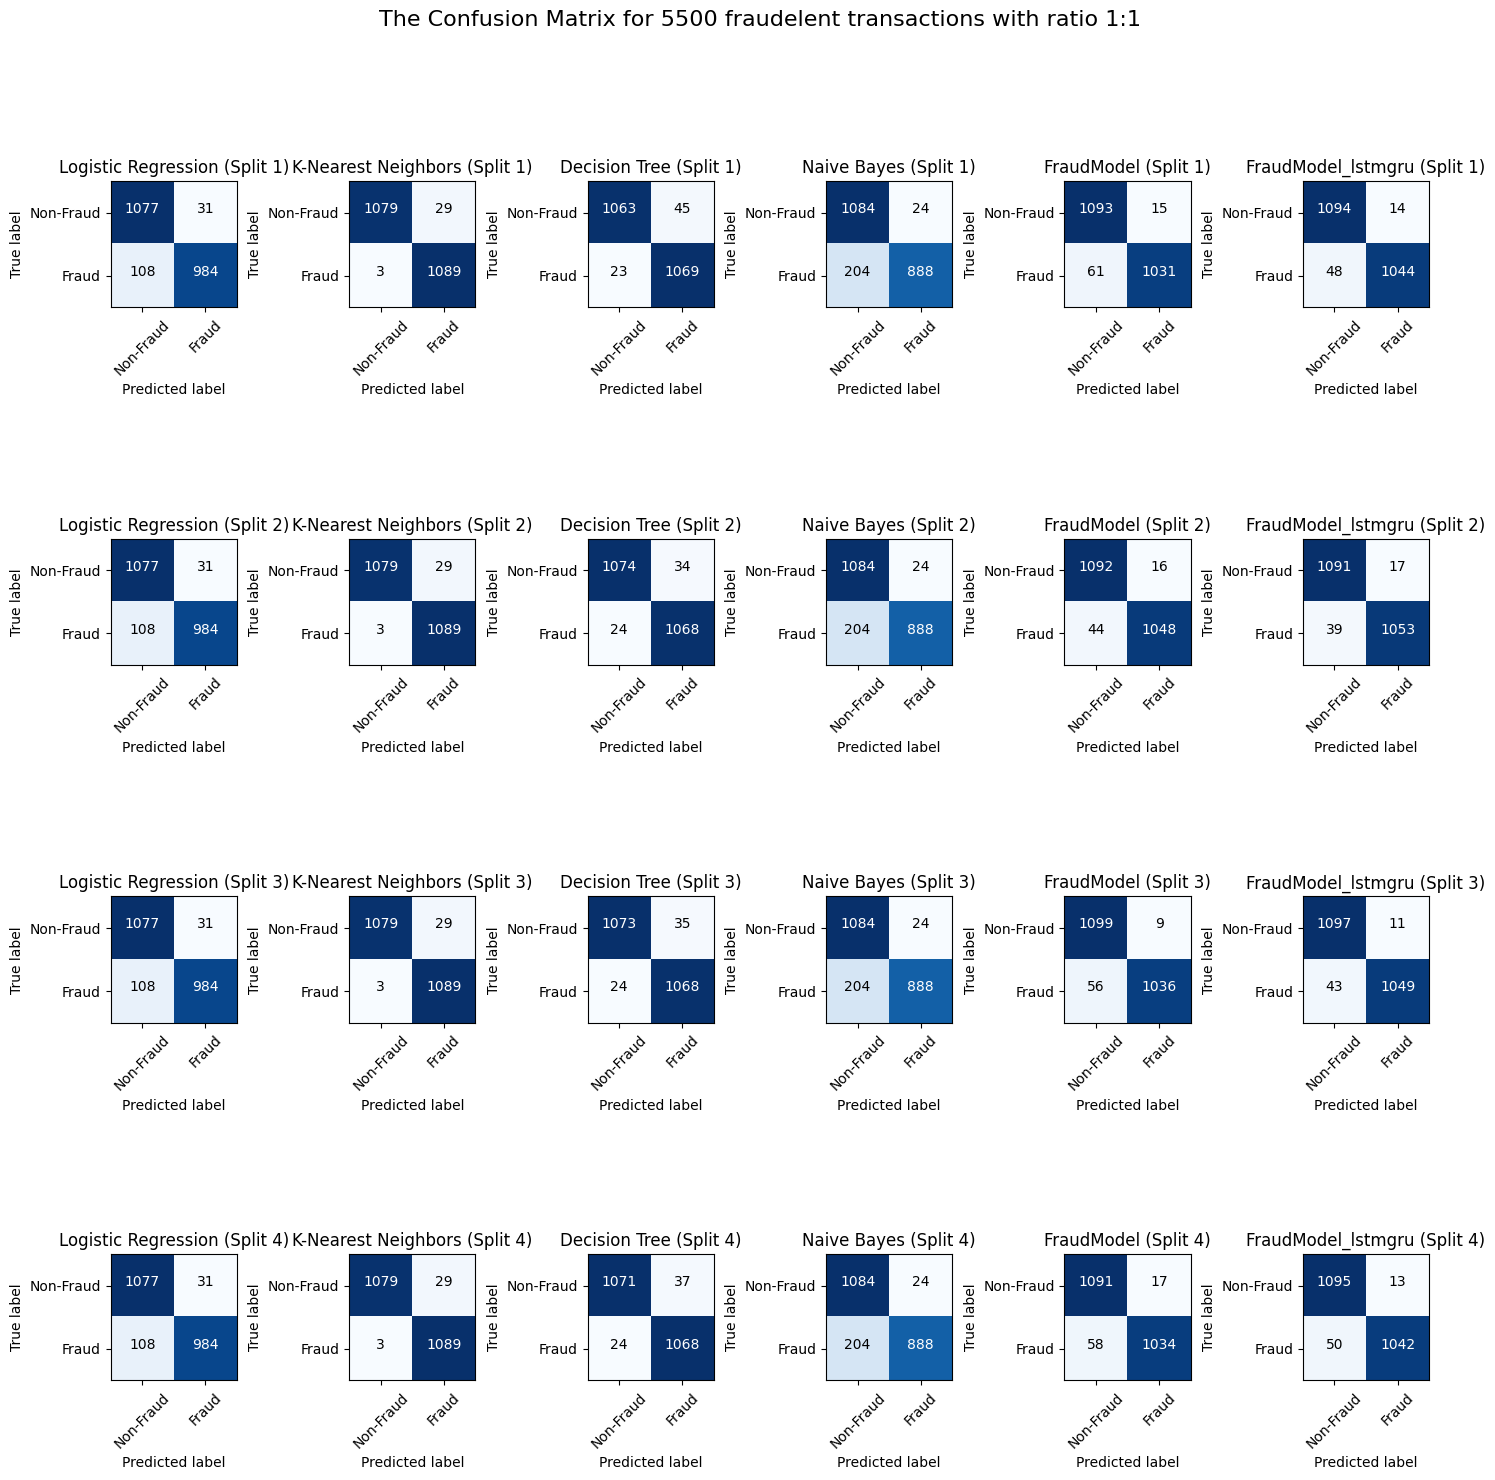

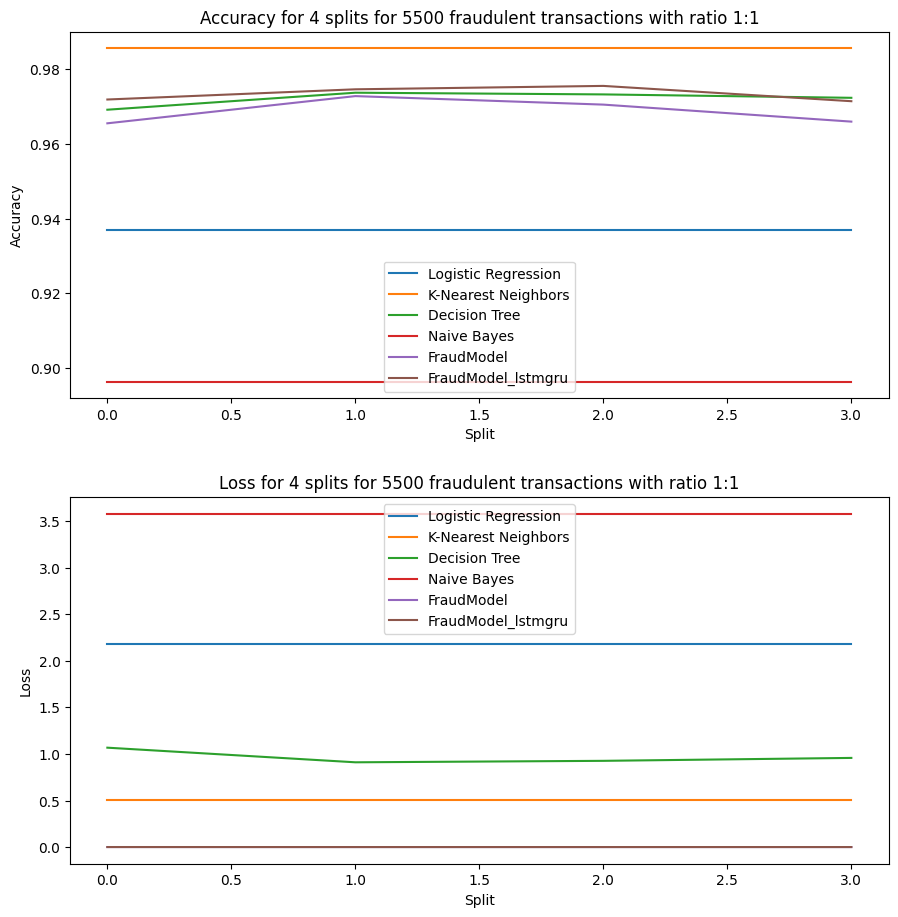

In [ ]:
print("\n##########################################################################\n")
print(f"This is for ratio 1:1")
print("\n##########################################################################\n")
for minor_rows in minor_rows_list:

    X_new = X_new_alldf[(1, minor_rows)]
    y_new = Y_new_alldf[(1, minor_rows)]

    metrics = {}

    for name in classifiers.keys():
        metrics[name] = {"accuracy": [], "loss": []}
    metrics["FraudModel"] = {"accuracy": [], "loss": []}
    metrics["FraudModel_lstmgru"] = {"accuracy": [], "loss": []}

    num_splits = 4
    num_classifiers = len(classifiers) + 2  # Add 1 for the CreditCardFraudModel and 1 for CreditCardFraudModel_lstmgru
    fig, axes = plt.subplots(num_splits, num_classifiers, figsize=(15, 15))
    fig.tight_layout(pad=5.0)
    fig.suptitle(f"The Confusion Matrix for {minor_rows} fraudelent transactions with ratio 1:1", fontsize=16, y=1.02)

    counter=1

    for train_index, test_index in skf.split(X_new, y_new):
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

        col_idx = 0

        print(f"This is Split number: {counter} for {minor_rows} fraudelent transactions with ratio 1:1")

        print("\n===========================================================================\n")

        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            loss = log_loss(y_test, y_pred)
            metrics[name]["accuracy"].append(accuracy)
            metrics[name]["loss"].append(loss)

            conf_mat = confusion_matrix(y_test, y_pred)
            plot_confusion_matrix(axes[counter - 1, col_idx], conf_mat, counter, name, minor_rows)
            col_idx += 1

            print(f"{name}:")
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}\n")

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = CreditCardFraudModel(X_train.shape[1]).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
        num_epochs = 15
        num_train_steps = num_epochs * len(train_loader)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_train_steps), num_training_steps=num_train_steps)

        precision, recall, f1, roc_auc, accuracy, conf_mat, running_loss_avg = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, scheduler, criterion, device)


        metrics["FraudModel"]["accuracy"].append(accuracy)
        running_loss_avg = running_loss_avg / len(train_loader)
        metrics["FraudModel"]["loss"].append(running_loss_avg)

        plot_confusion_matrix(axes[counter - 1, col_idx], conf_mat, counter, "FraudModel", minor_rows)

        print("\n***************************************************************************\n")
        print("For the FraudModel:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        print("\n===========================================================================\n")

        col_idx += 1

        model = CreditCardFraudModel_lstmgru(X_train.shape[1]).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
        num_epochs = 15
        num_train_steps = num_epochs * len(train_loader)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_train_steps), num_training_steps=num_train_steps)

        precision, recall, f1, roc_auc, accuracy, conf_mat, running_loss_avg = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, scheduler, criterion, device)


        metrics["FraudModel_lstmgru"]["accuracy"].append(accuracy)
        running_loss_avg = running_loss_avg / len(train_loader)
        metrics["FraudModel_lstmgru"]["loss"].append(running_loss_avg)

        plot_confusion_matrix(axes[counter - 1, col_idx], conf_mat, counter, "FraudModel_lstmgru", minor_rows)

        print("For the FraudModel_lstmgru:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        print("\n***************************************************************************\n")

        counter+=1

    plt.show()

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    fig.tight_layout(pad=5.0)

    # Plot accuracy
    for name, metric in metrics.items():
        axes[0].plot(metric["accuracy"], label=name)
    axes[0].set_title(f"Accuracy for {counter-1} splits for {minor_rows} fraudulent transactions with ratio 1:1")
    axes[0].set_xlabel("Split")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Plot loss
    for name, metric in metrics.items():
        if metric["loss"]:
            axes[1].plot(metric["loss"], label=name)
    axes[1].set_title(f"Loss for {counter-1} splits for {minor_rows} fraudulent transactions with ratio 1:1")
    axes[1].set_xlabel("Split")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

In [ ]:
# Main program
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=4)
criterion = nn.BCELoss()

File to large email me for full code file\
Thanks!